# Time Series Analysis of Doubleknit Fabric Demand

In [2]:
# Install required packages if needed
# install.packages(c("ggplot2", "forecast", "TSA", "tseries", "dplyr",
#                   "lubridate", "gridExtra", "MASS", "knitr", "lawstat",
#                   "FinTS", "ggthemes"))


In [3]:
# Load required libraries
library(ggplot2)
library(forecast)
library(tseries)
library(dplyr)
library(lubridate)
library(gridExtra)
library(MASS)
library(knitr)
library(lawstat)
library(FinTS)
library(TSA)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘lawstat’


The following object is masked from ‘package:tseries’:

    runs.test


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘FinTS’


The following object is masked from ‘package:forecast’:

    Acf


Registered S3 methods overwri

In [4]:
# Plot settings
options(repr.plot.width = 20, repr.plot.height = 10)
theme_tsa <- function() {
  theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
      plot.subtitle = element_text(hjust = 0.5, size = 12),
      axis.title = element_text(face = "bold"),
      legend.position = "bottom",
      panel.grid.minor = element_line(color = "gray90"),
      panel.grid.major = element_line(color = "gray85")
    )
}

In [6]:
fabric_df <- read.csv("../data/Demand for a doubleknit fabric p269 Montgomery Fore TS.csv")

# Data has no explicit dates, so we'll create a sequence
# Assuming monthly data starting from January 2005
start_date <- as.Date("2005-01-01")
dates <- seq.Date(from = start_date, by = "month", length.out = nrow(fabric_df))

# Create a dataframe with dates and demand values
fabric_ts_df <- data.frame(
  date = dates,
  demand = fabric_df$x
)


In [7]:

# Summary statistics
cat("Dataset summary:\n")
print(summary(fabric_ts_df$demand))

cat("\nDate range:", format(min(fabric_ts_df$date), "%Y-%m-%d"),
    "to", format(max(fabric_ts_df$date), "%Y-%m-%d"), "\n")

cat("\nDemand range:", min(fabric_ts_df$demand),
    "to", max(fabric_ts_df$demand), "units\n")

missing_values <- colSums(is.na(fabric_ts_df))
cat("\nMissing values by column:\n")
print(missing_values)

Dataset summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  467.0   560.8   600.0   591.6   625.5   704.0 

Date range: 2005-01-01 to 2024-12-01 

Demand range: 467 to 704 units

Missing values by column:
  date demand 
     0      0 


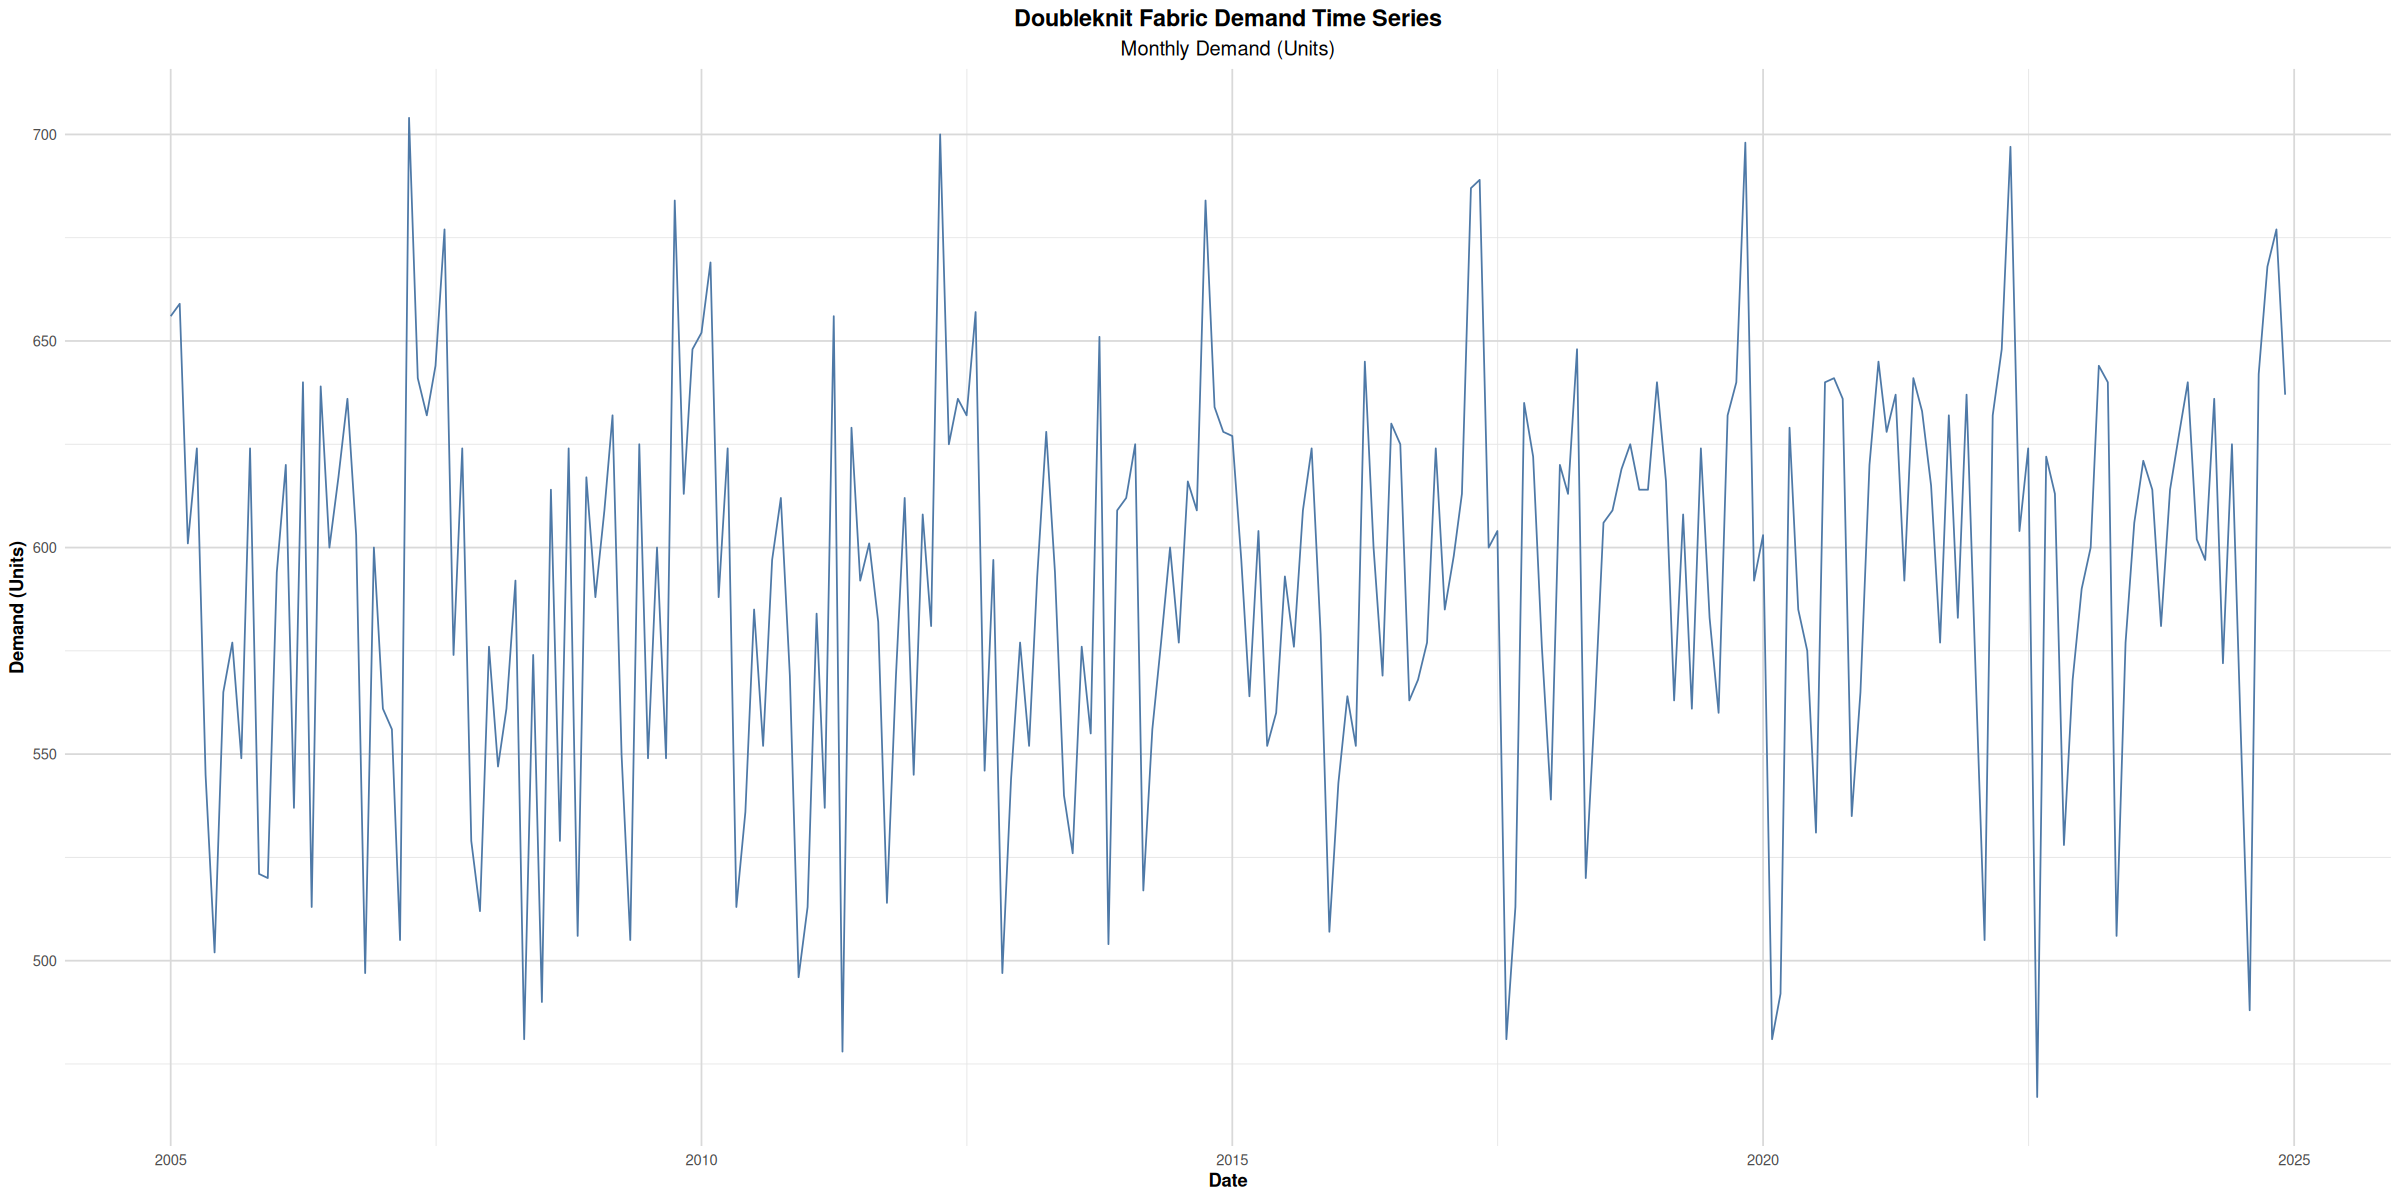

In [8]:
# Plot the time series
p1 <- ggplot(fabric_ts_df, aes(x = date, y = demand)) +
  geom_line(color = "#4E79A7") +
  labs(
    title = "Doubleknit Fabric Demand Time Series",
    subtitle = "Monthly Demand (Units)",
    x = "Date",
    y = "Demand (Units)"
  ) +
  theme_tsa()

print(p1)

In [9]:

# Create a ts object
fabric_ts <- ts(fabric_ts_df$demand, 
                frequency = 12,  # Assuming monthly data
                start = c(year(min(fabric_ts_df$date)), 
                          month(min(fabric_ts_df$date))))

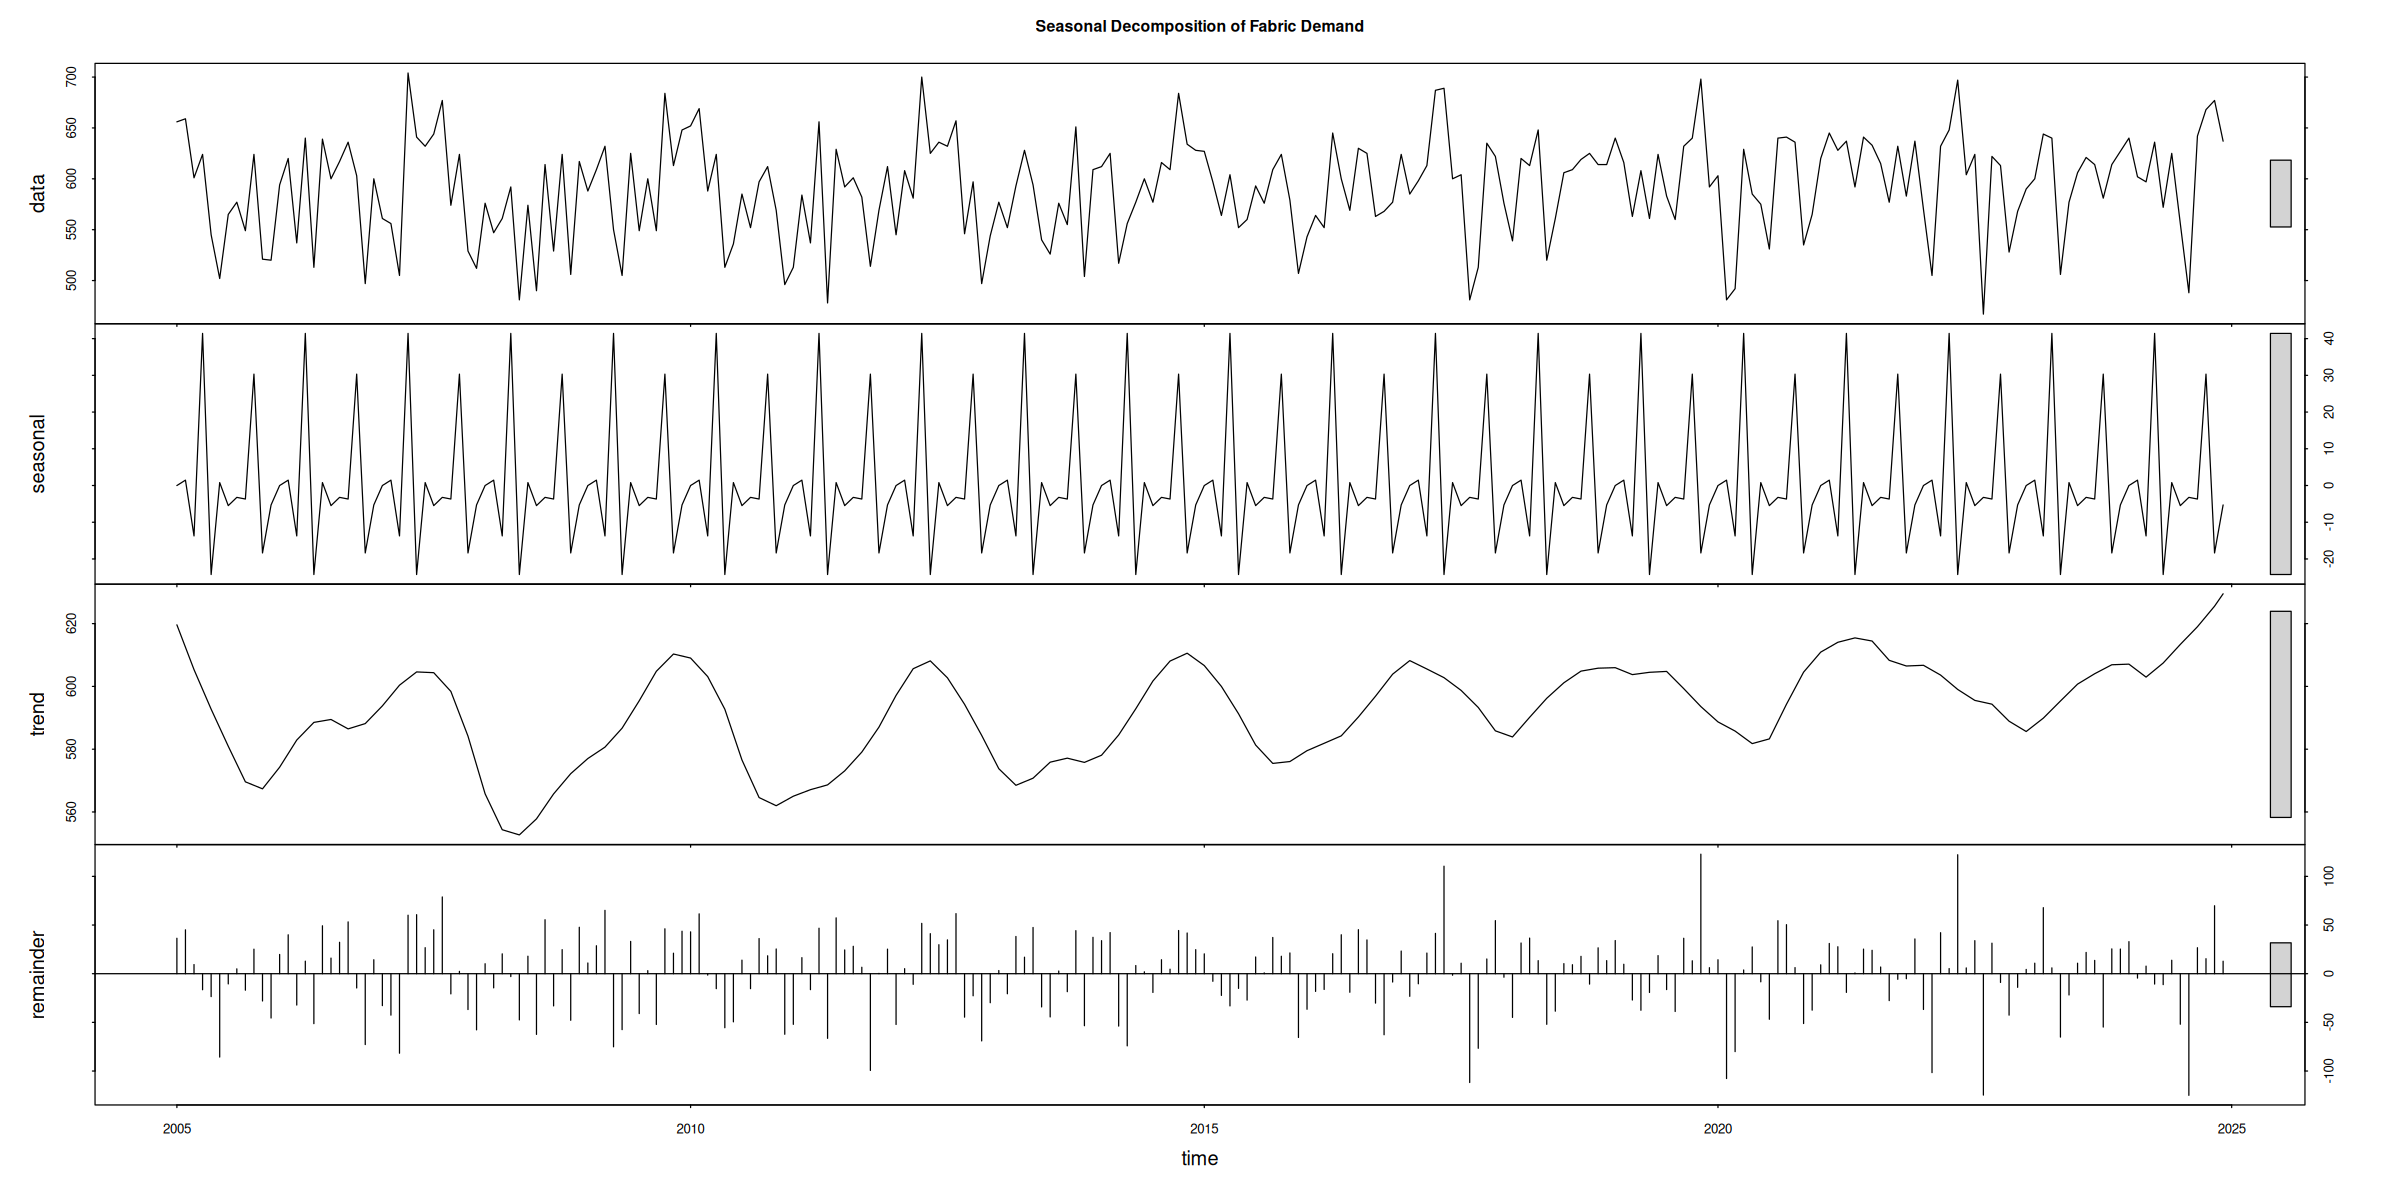

In [11]:
# Seasonal decomposition
par(bg = "white")
decomp <- stl(fabric_ts, s.window="periodic")
plot(decomp, main="Seasonal Decomposition of Fabric Demand")

In [12]:

# Month-by-month boxplot to visualize seasonal patterns
fabric_ts_df$month <- month(fabric_ts_df$date, label = TRUE)
fabric_ts_df$year <- year(fabric_ts_df$date)

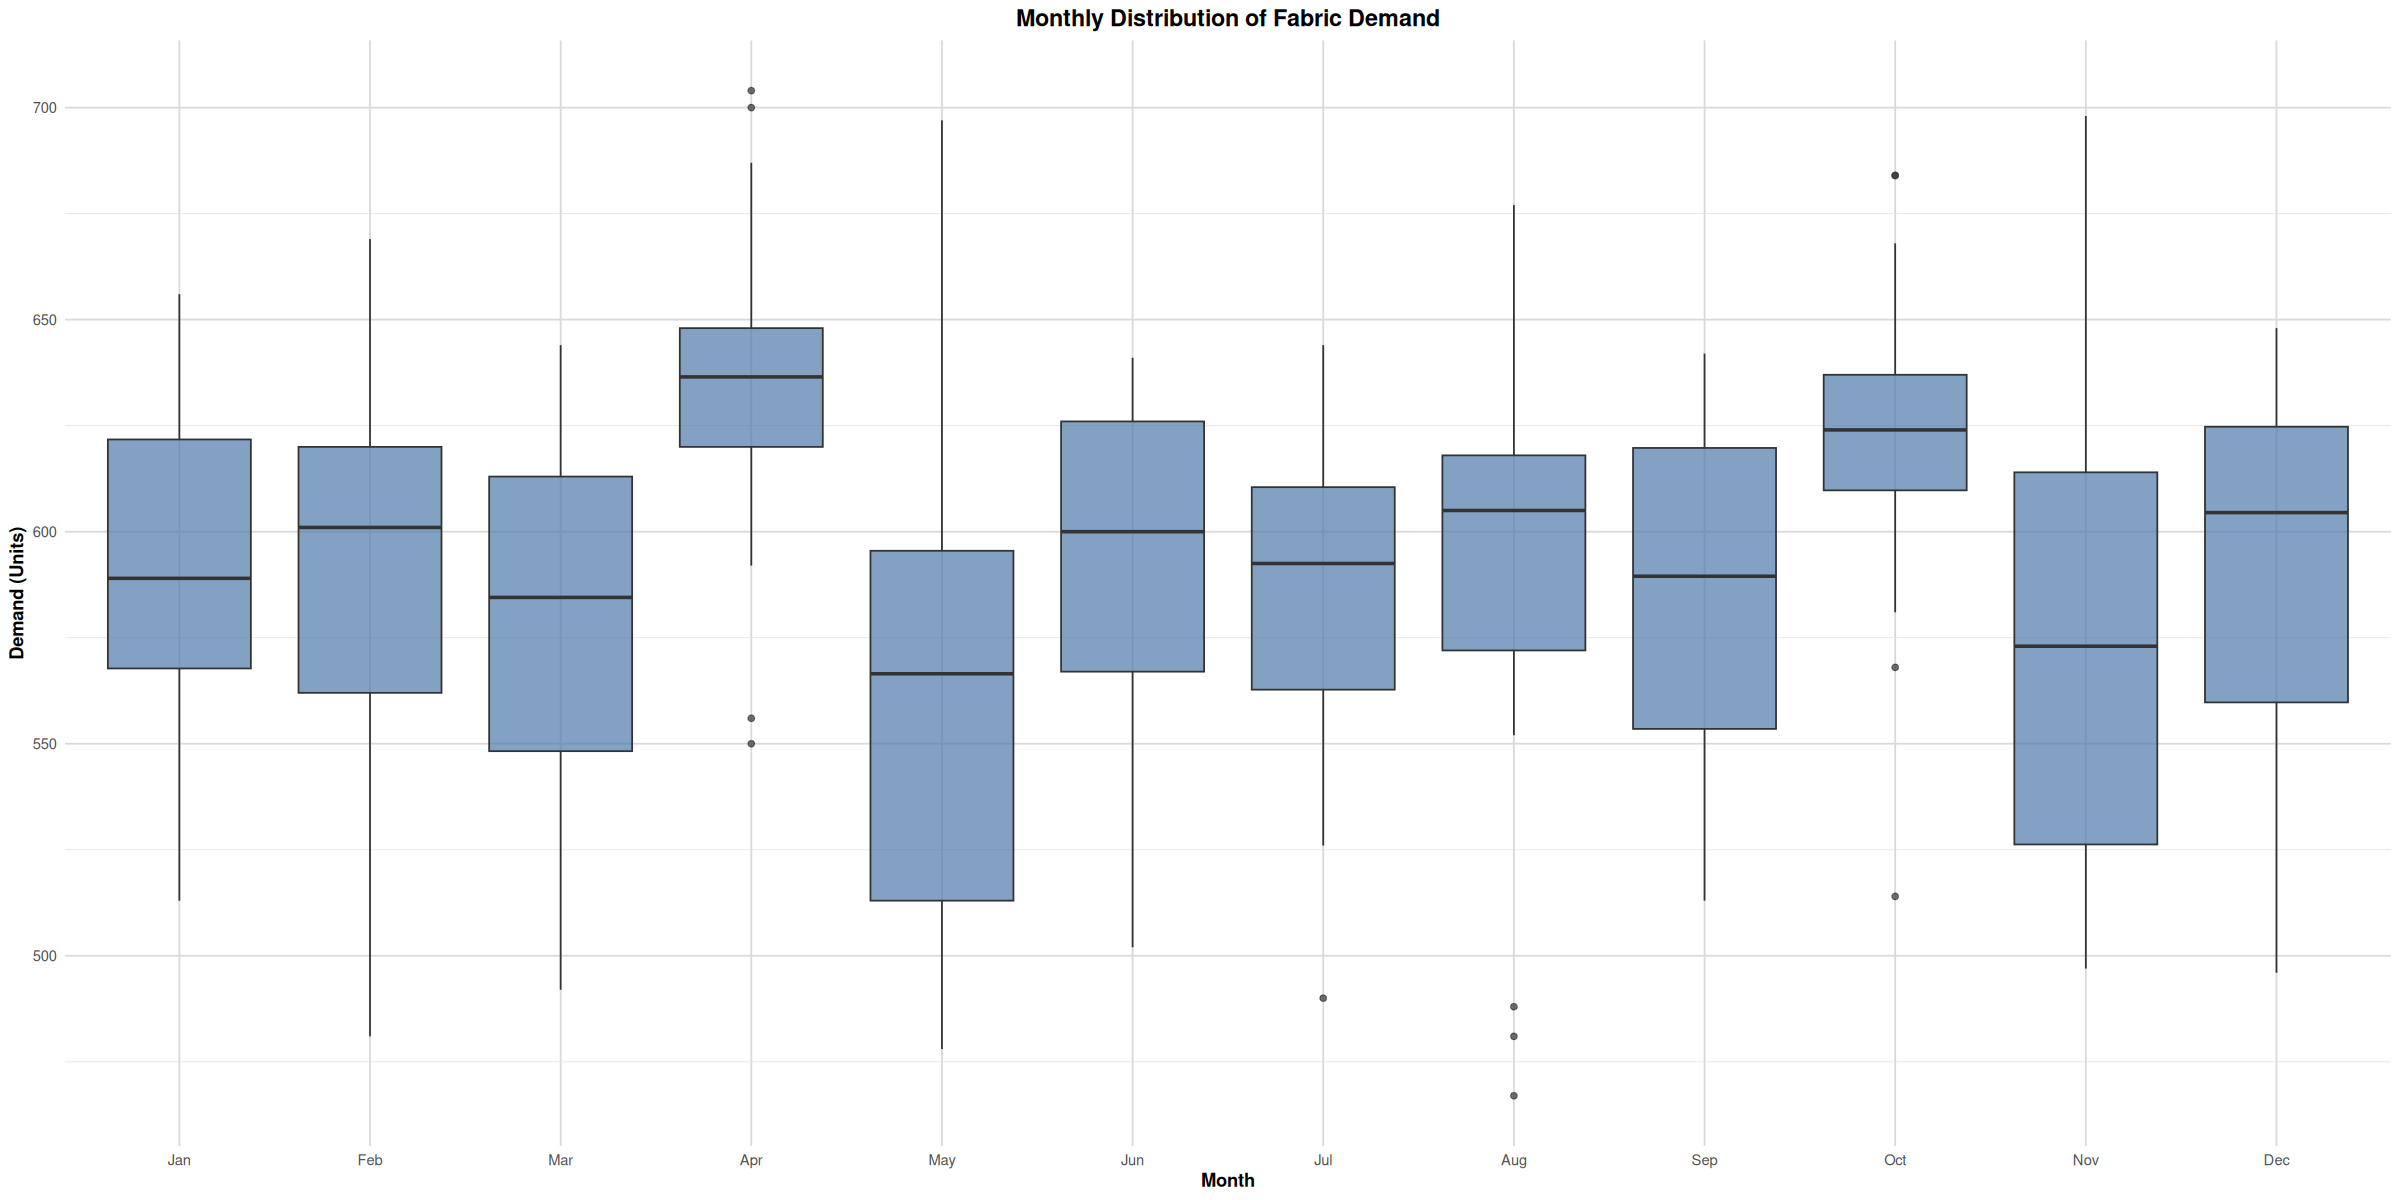

In [13]:
p_box <- ggplot(fabric_ts_df, aes(x = month, y = demand, group = month)) +
  geom_boxplot(fill = "#4E79A7", alpha = 0.7) +
  labs(
    title = "Monthly Distribution of Fabric Demand",
    x = "Month",
    y = "Demand (Units)"
  ) +
  theme_tsa()

print(p_box)

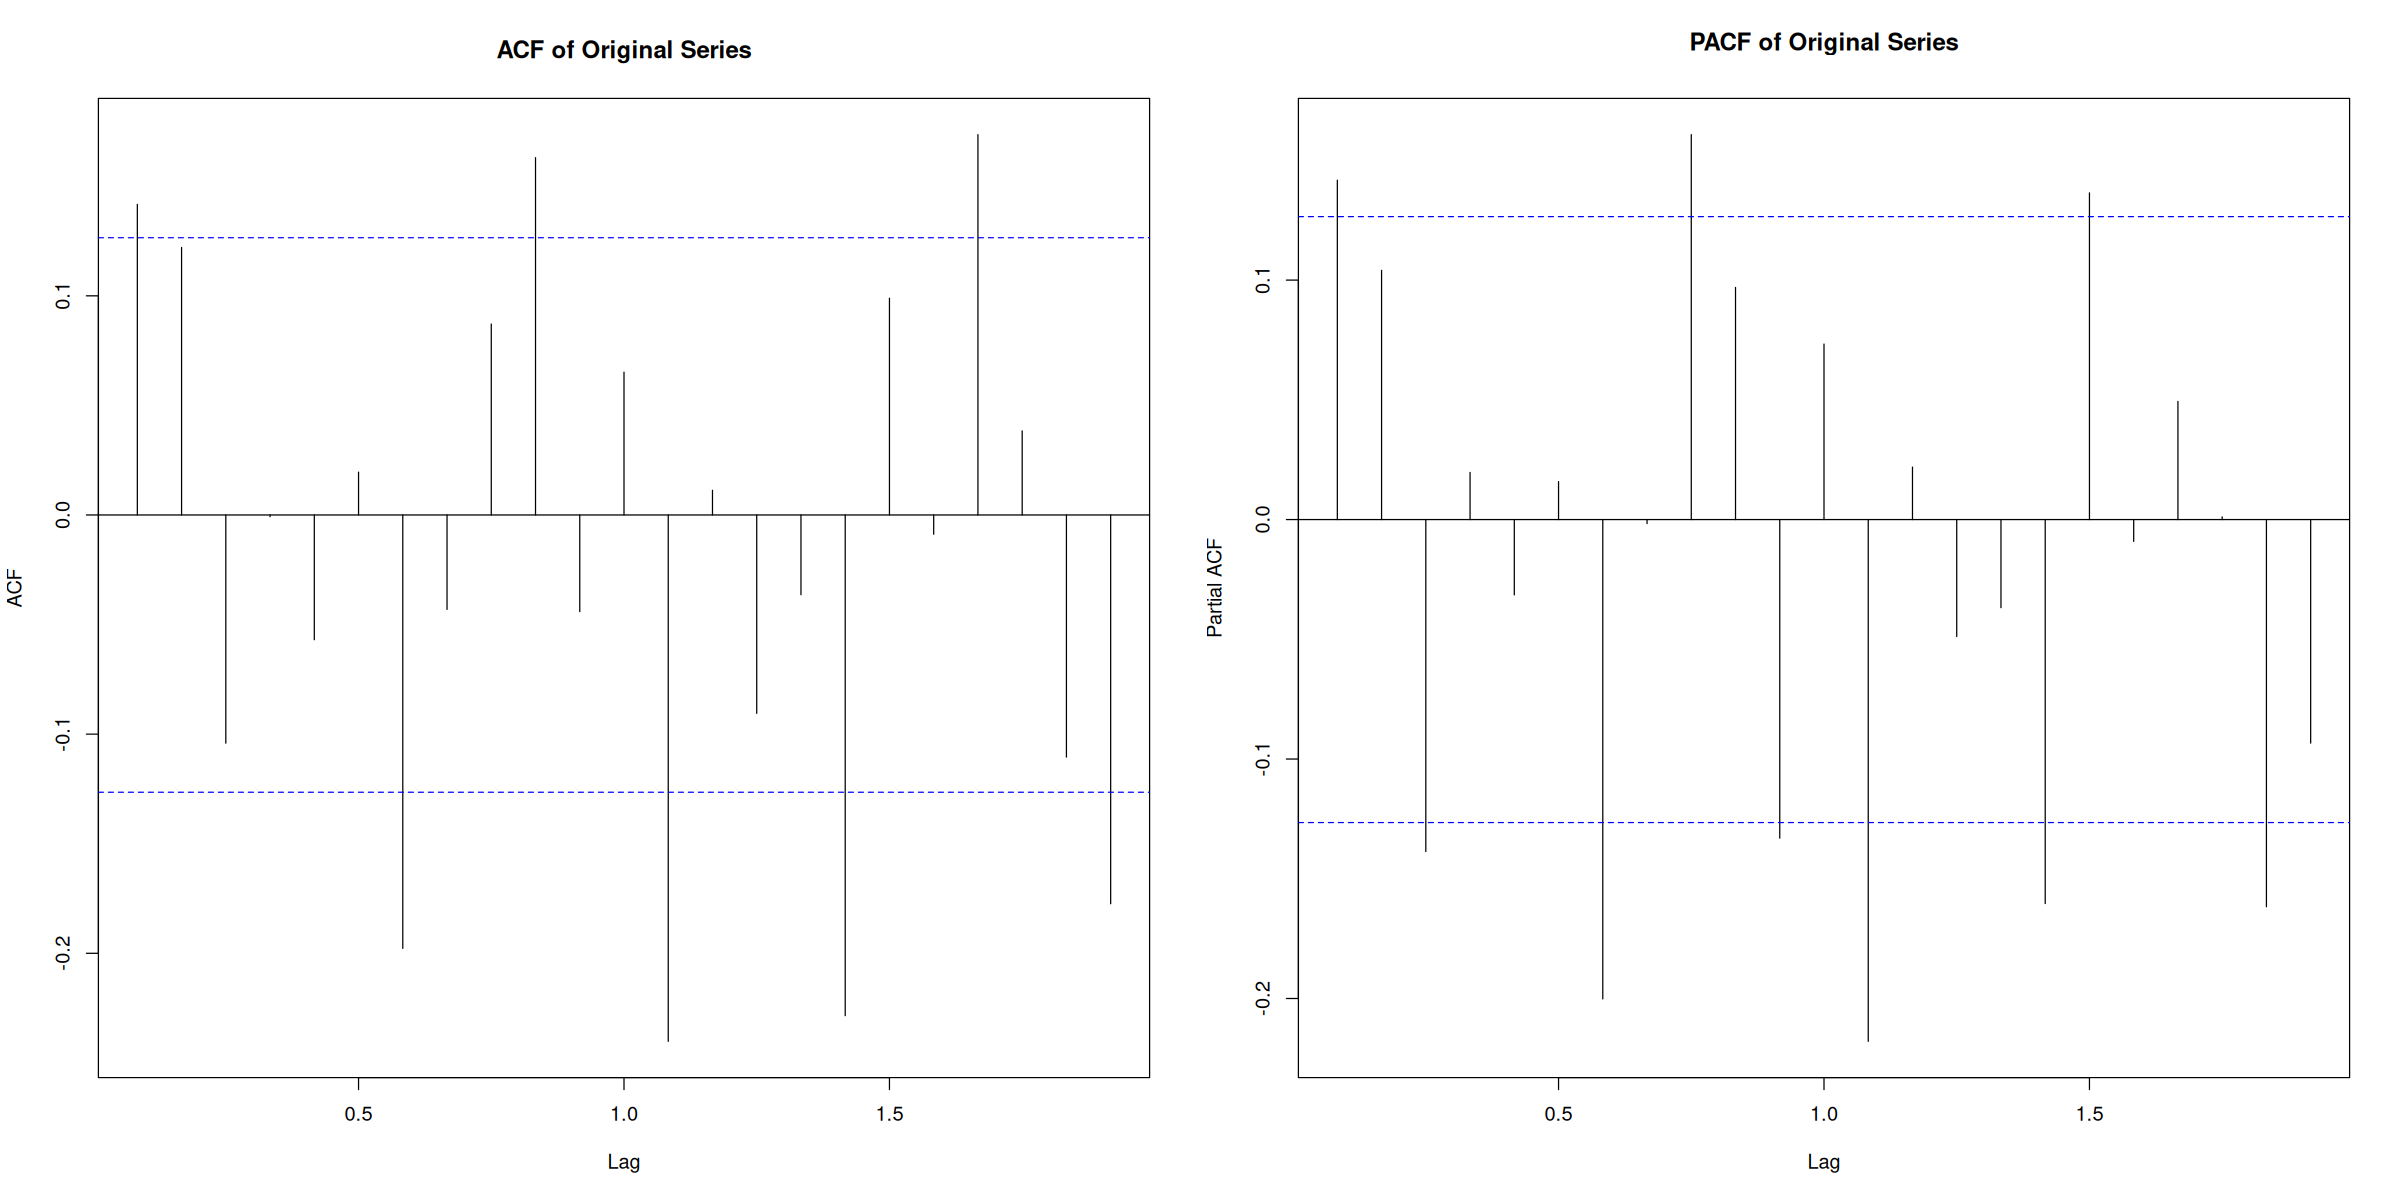

In [15]:
# ACF and PACF of original series
par(mfrow=c(1,2), bg="white")
acf(fabric_ts, main="ACF of Original Series")
pacf(fabric_ts, main="PACF of Original Series")
par(mfrow=c(1,1))

Optimal lambda for Box-Cox transformation: 1.999924 
Using Box-Cox transformation with lambda = 1.999924 


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Original vs Box-Cox Transformation (λ = 1.9999 )' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Original vs Box-Cox Transformation (λ = 1.9999 )' in 'mbcsToSbcs': dot substituted for <bb>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Original vs Box-Cox Transformation (λ = 1.9999 )' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Original vs Box-Cox Transformation (λ = 1.9999 )' in 'mbcsToSbcs': dot substituted for <bb>”


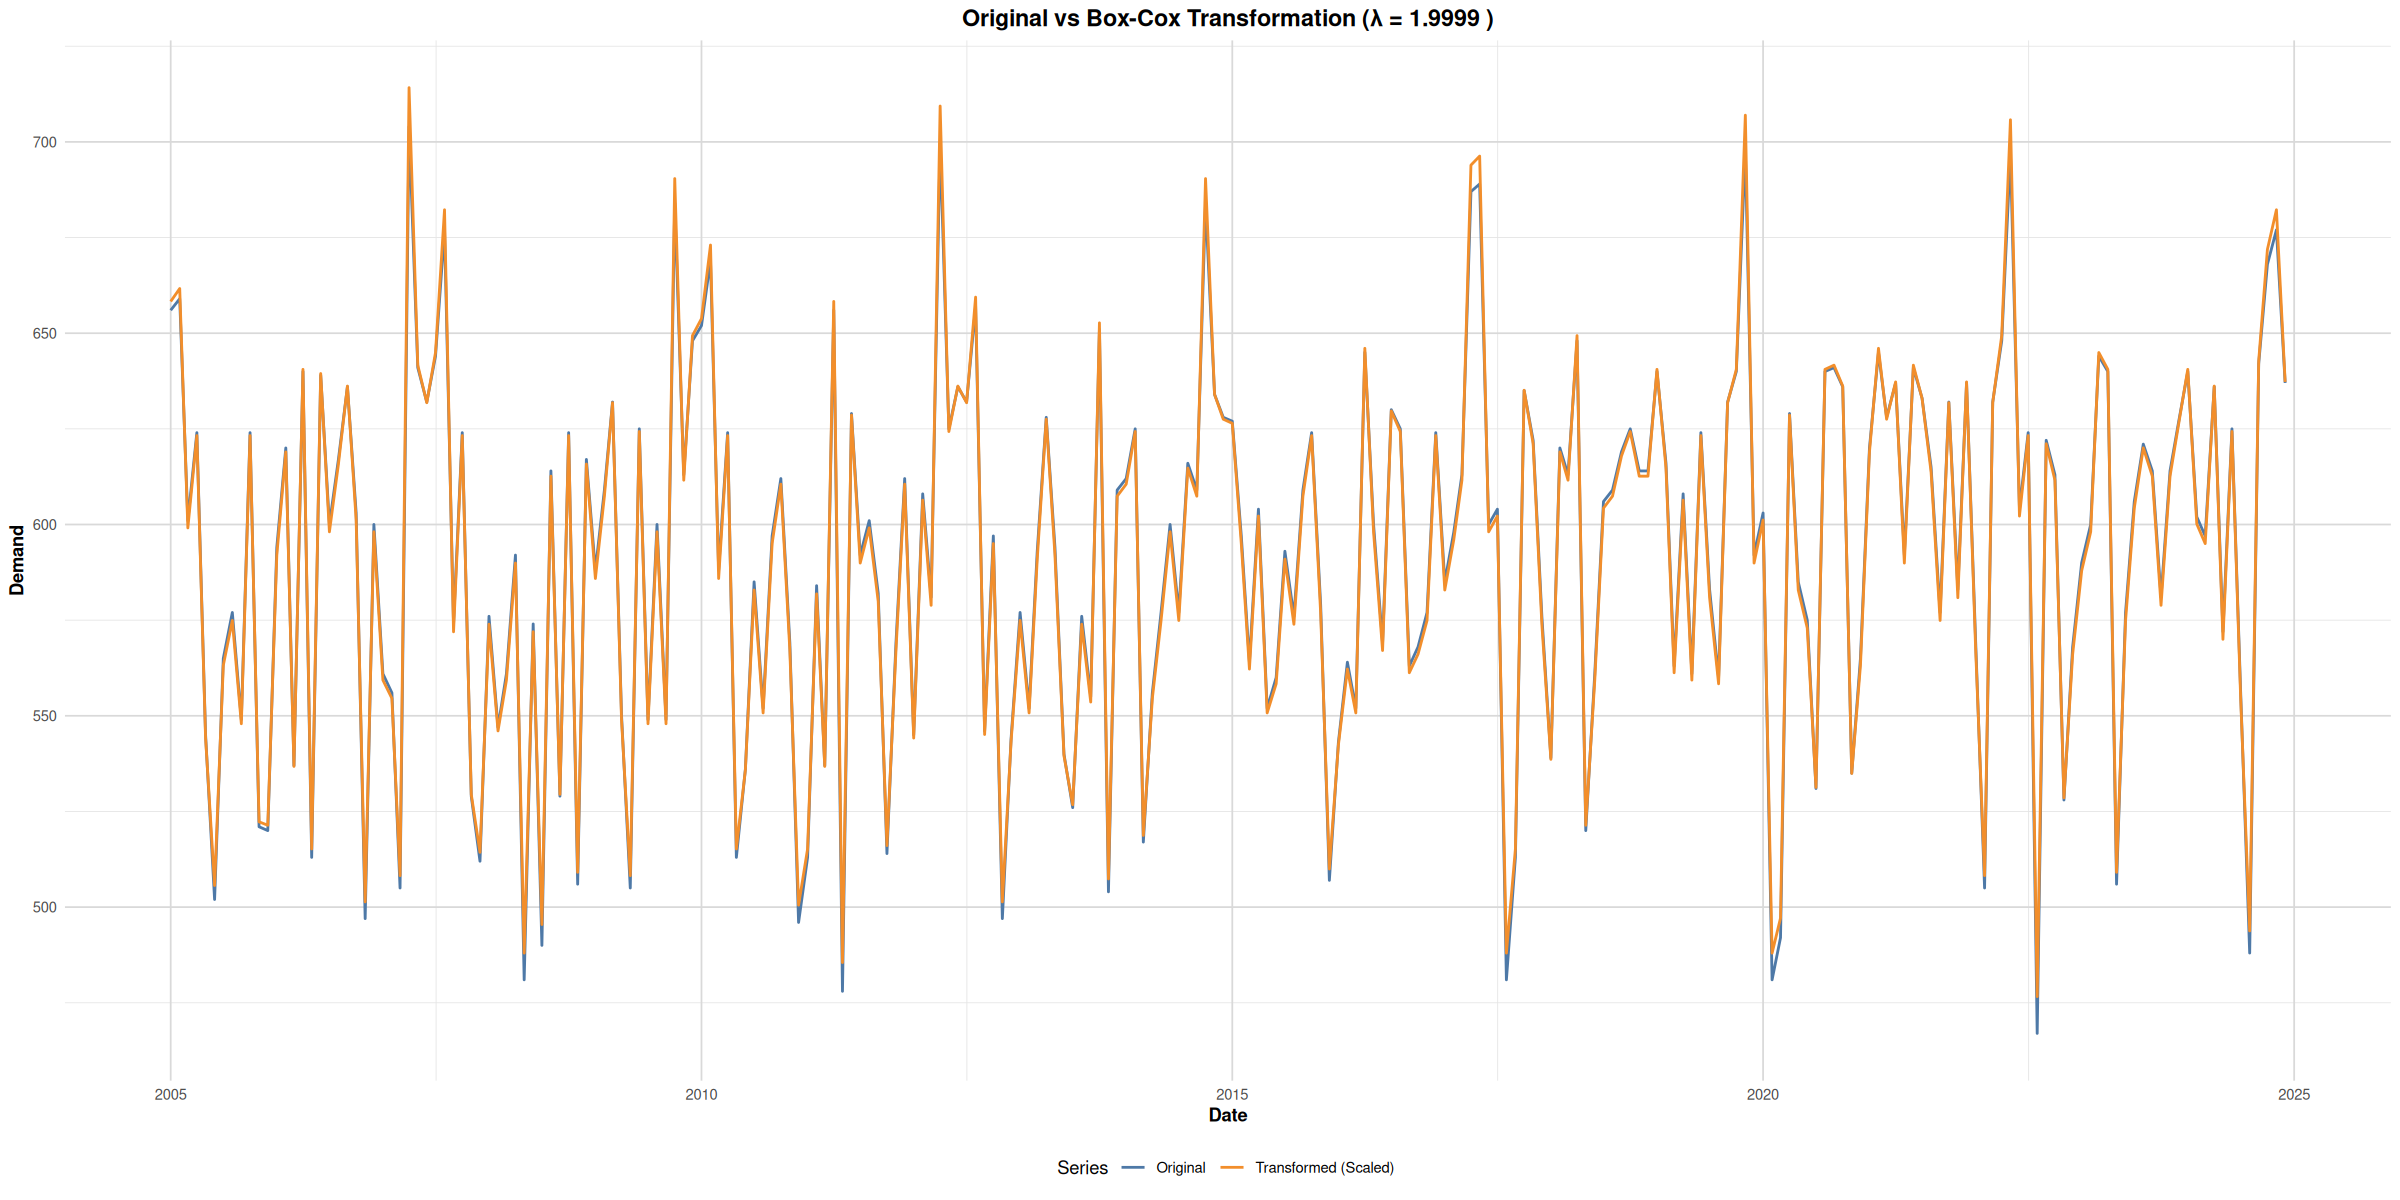

In [16]:
# Box-Cox transformation test
lambda <- BoxCox.lambda(fabric_ts)
cat("Optimal lambda for Box-Cox transformation:", lambda, "\n")

if (abs(lambda) < 0.1) {
    cat("Lambda is close to 0, using log transformation\n")
    transformed_ts <- log(fabric_ts)
    transformation_label <- "Log Transformation"
} else if (abs(lambda - 1) < 0.1) {
    cat("Lambda is close to 1, no transformation needed\n")
    transformed_ts <- fabric_ts
    transformation_label <- "No Transformation"
} else {
    cat("Using Box-Cox transformation with lambda =", lambda, "\n")
    transformed_ts <- BoxCox(fabric_ts, lambda)
    transformation_label <- paste("Box-Cox Transformation (λ =", round(lambda, 4), ")")
}

transformed_df <- data.frame(
    Date = fabric_ts_df$date,
    Original = as.numeric(fabric_ts),
    Transformed = as.numeric(transformed_ts)
)

p_trans <- ggplot(transformed_df, aes(x = Date)) +
    geom_line(aes(y = Original, color = "Original"), linewidth = 0.8) +
    geom_line(aes(
        y = scale(Transformed) * sd(Original) + mean(Original),
        color = "Transformed (Scaled)"
    ), linewidth = 0.8) +
    labs(
        title = paste("Original vs", transformation_label),
        x = "Date", y = "Demand",
        color = "Series"
    ) +
    scale_color_manual(values = c("Original" = "#4E79A7", "Transformed (Scaled)" = "#F28E2B")) +
    theme_tsa()

print(p_trans)

In [ ]:
# Test for stationarity using ADF test and KPSS test
adf_test <- adf.test(transformed_ts, alternative = "stationary")
kpss_test <- kpss.test(transformed_ts, null = "Trend")

cat("ADF Test for Stationarity:\n")
print(adf_test)

cat("\nKPSS Test for Stationarity:\n")
print(kpss_test)

cat("\nConclusion:\n")
if (adf_test$p.value < 0.05) {
    cat("ADF test rejects the null hypothesis, series is stationary\n")
} else {
    cat("ADF test fails to reject the null hypothesis, series is non-stationary\n")
}
if (kpss_test$p.value < 0.05) {
    cat("KPSS test rejects the null hypothesis, series is non-stationary\n")
} else {
    cat("KPSS test fails to reject the null hypothesis, series is stationary\n")
}

Warning message in adf.test(transformed_ts, alternative = "stationary"):
“p-value smaller than printed p-value”
Warning message in kpss.test(transformed_ts, null = "Trend"):
“p-value greater than printed p-value”


ADF Test for Stationarity:

	Augmented Dickey-Fuller Test

data:  transformed_ts
Dickey-Fuller = -7.5682, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


KPSS Test for Stationarity:

	KPSS Test for Trend Stationarity

data:  transformed_ts
KPSS Trend = 0.026458, Truncation lag parameter = 4, p-value = 0.1


Conclusion:
ADF test rejects the null hypothesis, series is stationary
KPSS test fails to reject the null hypothesis, series is stationary


**Series is stationary no need for differencing**

In [18]:
# # Check if differencing is needed based on ADF and KPSS tests
# if (adf_test$p.value >= 0.05 || kpss_test$p.value < 0.05) {
#     cat("\nApplying differencing to achieve stationarity\n")
#     diff_ts <- diff(transformed_ts)
    
#     # Plot differenced series
#     diff_df <- data.frame(
#         Date = fabric_ts_df$date[-1],
#         Differenced = as.numeric(diff_ts)
#     )
    
#     p_diff <- ggplot(diff_df, aes(x = Date, y = Differenced)) +
#         geom_line(color = "#4E79A7") +
#         labs(
#             title = "Differenced Series",
#             x = "Date", 
#             y = "Differenced Value"
#         ) +
#         theme_tsa()
    
#     print(p_diff)
    
#     # Test differenced series for stationarity
#     adf_diff <- adf.test(diff_ts, alternative = "stationary")
#     kpss_diff <- kpss.test(diff_ts, null = "Trend")
    
#     cat("\nADF Test for Stationarity (After Differencing):\n")
#     print(adf_diff)
    
#     cat("\nKPSS Test for Stationarity (After Differencing):\n")
#     print(kpss_diff)
    
#     cat("\nConclusion (After Differencing):\n")
#     if (adf_diff$p.value < 0.05) {
#         cat("ADF test rejects the null hypothesis, series is stationary\n")
#     } else {
#         cat("ADF test fails to reject the null hypothesis, series is non-stationary\n")
#     }
#     if (kpss_diff$p.value < 0.05) {
#         cat("KPSS test rejects the null hypothesis, series is non-stationary\n")
#     } else {
#         cat("KPSS test fails to reject the null hypothesis, series is stationary\n")
#     }
    
#     # Use differenced series for analysis if it's stationary
#     if (adf_diff$p.value < 0.05 && kpss_diff$p.value >= 0.05) {
#         analysis_ts <- diff_ts
#         d_value <- 1  # Differencing order
#         cat("\nUsing differenced series for analysis (d = 1)\n")
#     } else {
#         analysis_ts <- transformed_ts
#         d_value <- 0  # No differencing
#         cat("\nUsing transformed series without differencing for analysis (d = 0)\n")
#     }
# } else {
#     analysis_ts <- transformed_ts
#     d_value <- 0  # No differencing
#     cat("\nSeries is already stationary, no differencing needed (d = 0)\n")
# }


Using transformed series without differencing for analysis (d = 0)


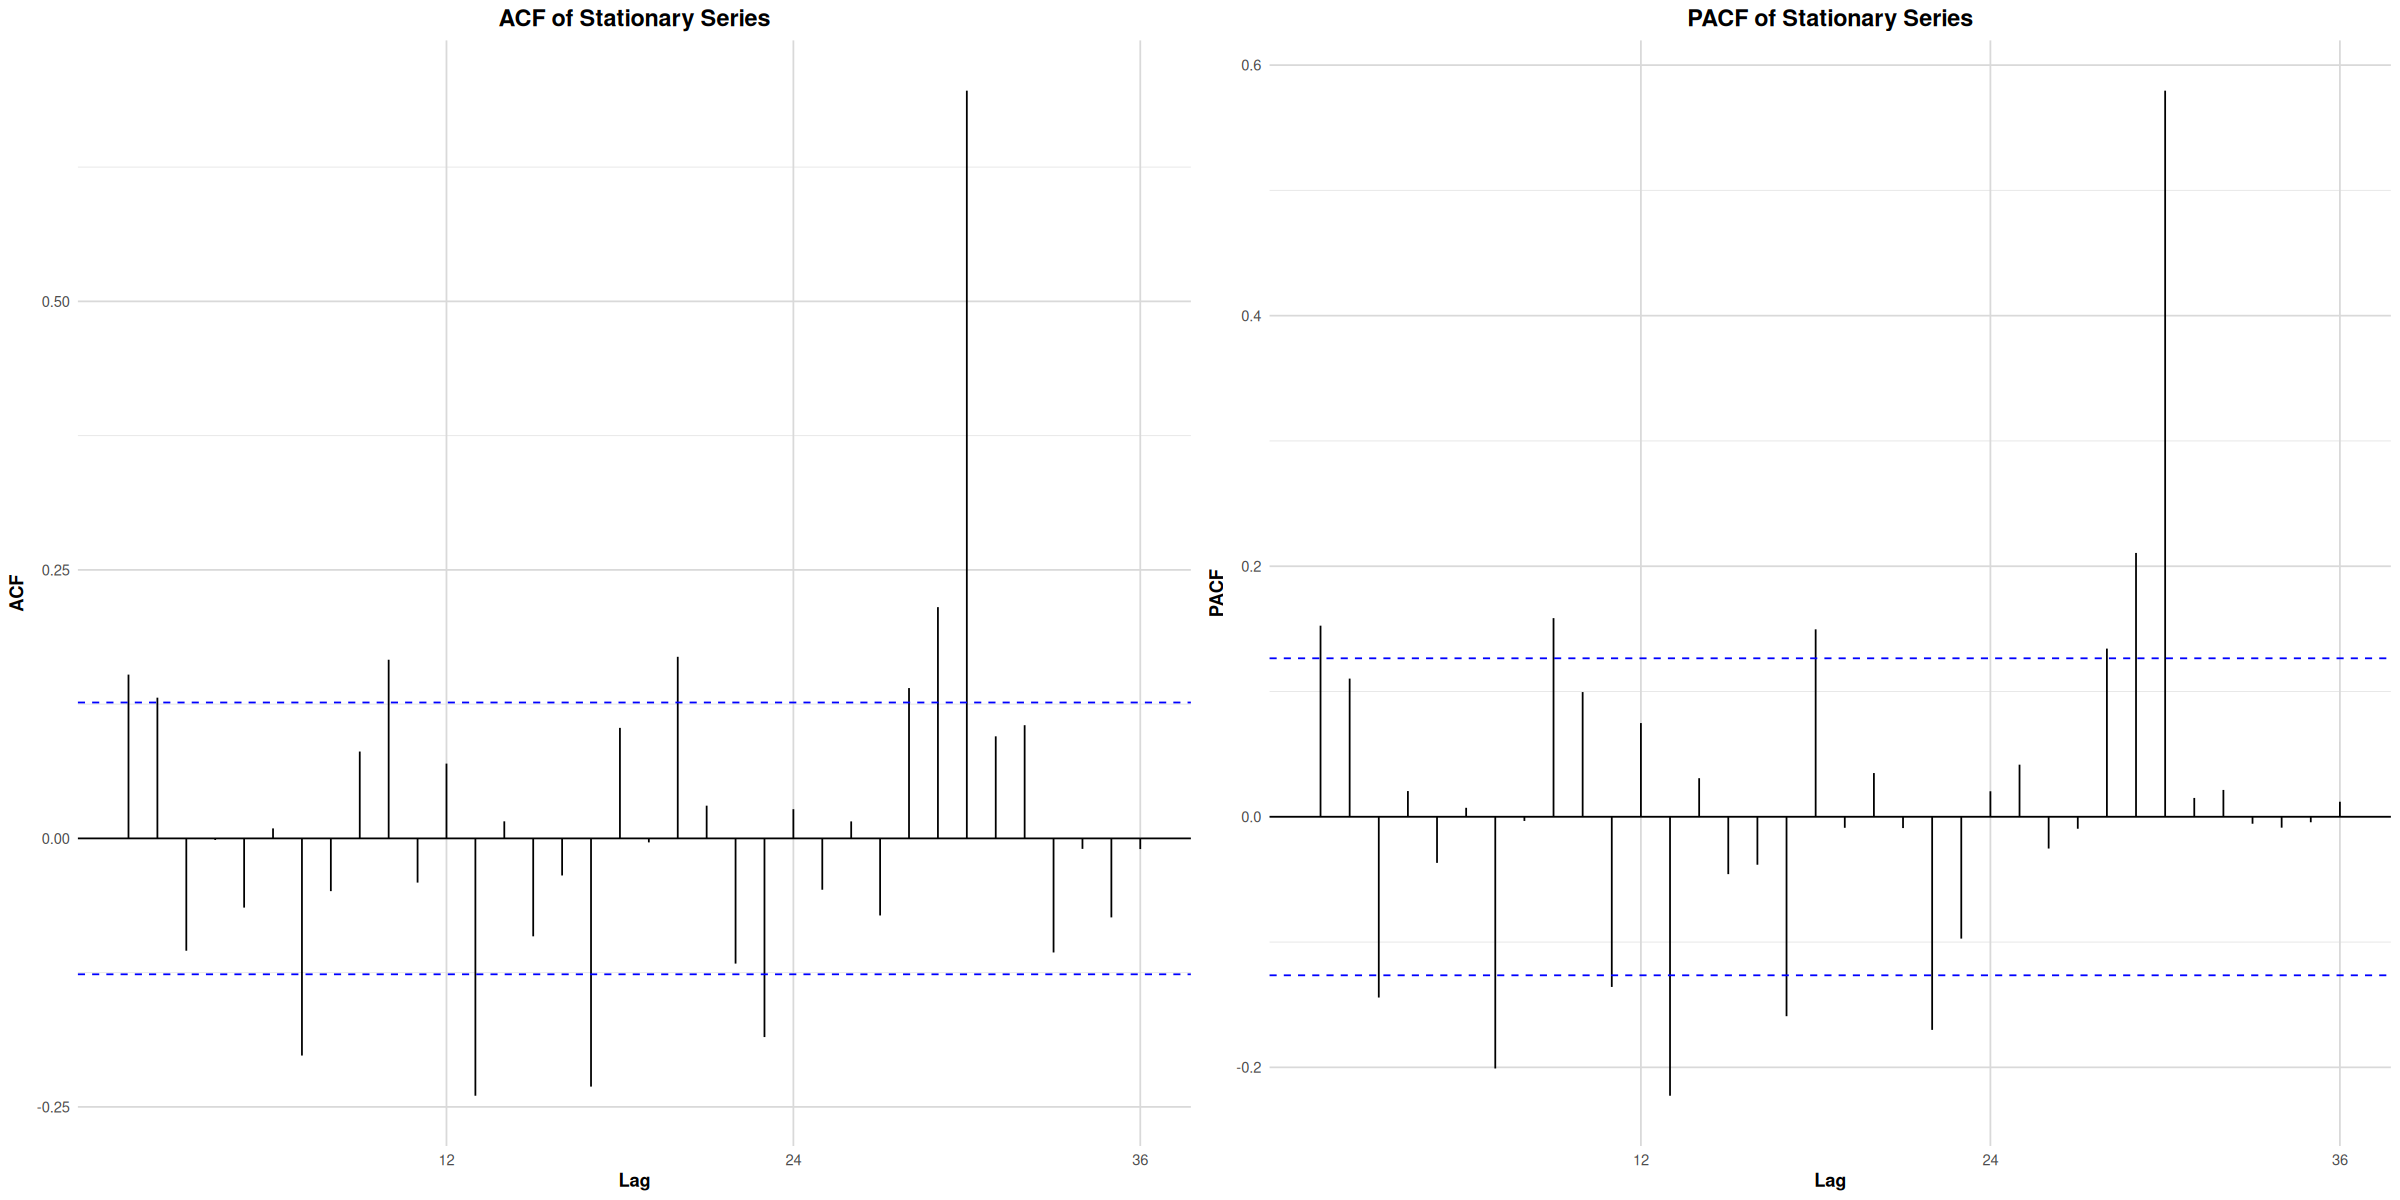

In [20]:
analysis_ts <- transformed_ts
d_value <- 0  # No differencing
cat("\nUsing transformed series without differencing for analysis (d = 0)\n")
# ACF and PACF of the transformed series

# Plot ACF and PACF of the stationary series
p_acf <- ggAcf(analysis_ts, lag.max = 36) +
    labs(title = "ACF of Stationary Series") +
    theme_tsa()

p_pacf <- ggPacf(analysis_ts, lag.max = 36) +
    labs(title = "PACF of Stationary Series") +
    theme_tsa()

grid.arrange(p_acf, p_pacf, ncol = 2)

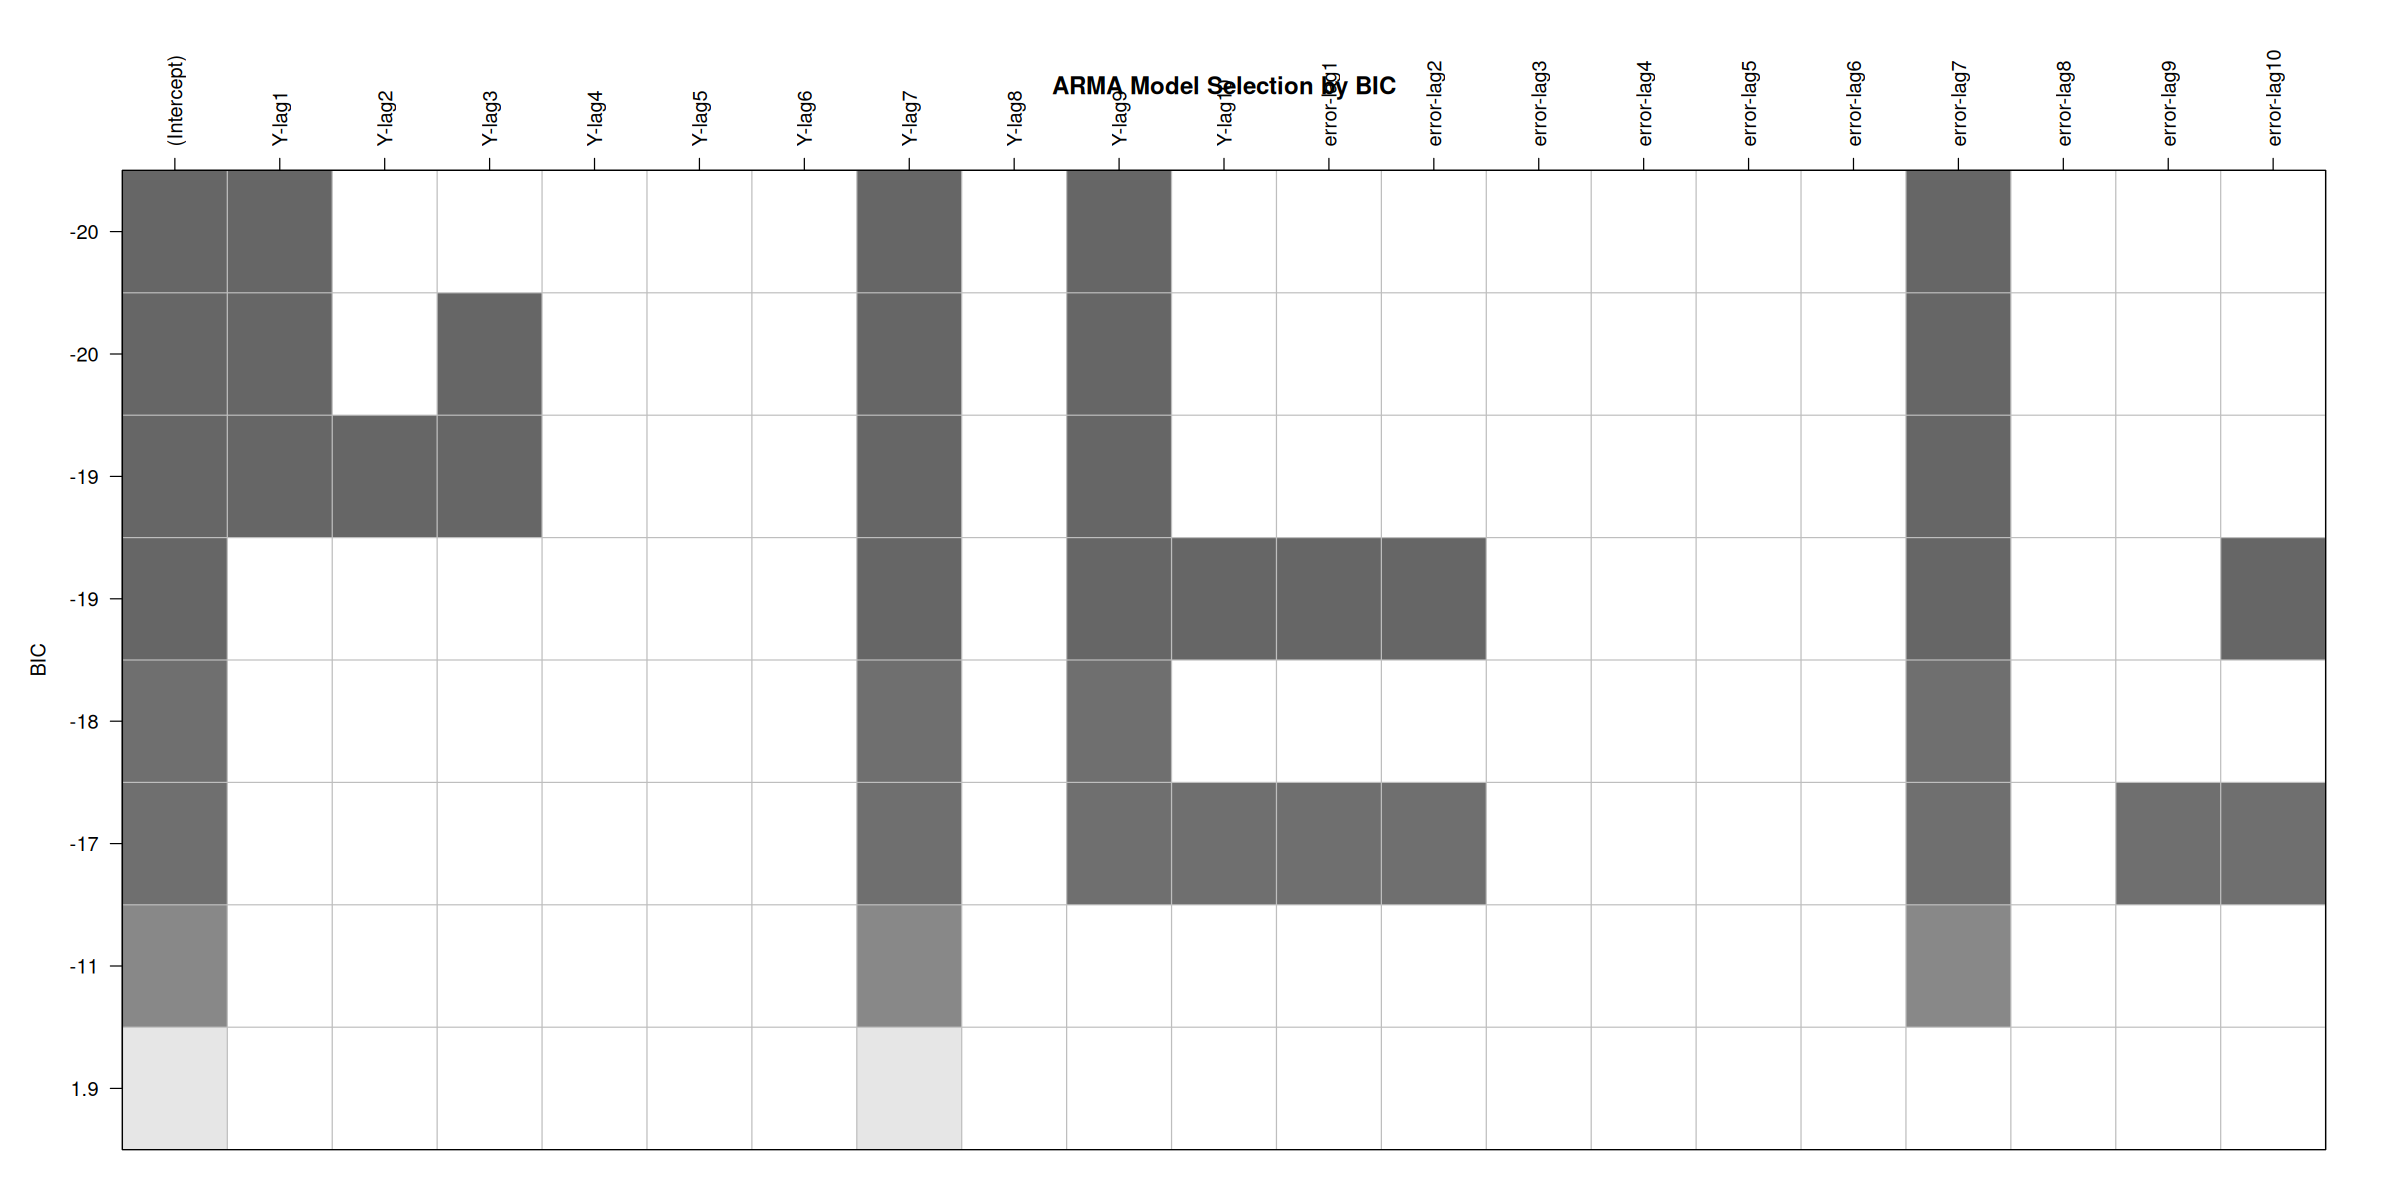

In [22]:
# ARMASUBSETS for model identification
subset_results <- armasubsets(y = analysis_ts, nar = 10, nma = 10, ar.method = "ols")

# Plot results
par(mfrow=c(1,1), bg = "white")
plot(subset_results, which = "bic", main = "ARMA Model Selection by BIC",
     xlab = "AR and MA terms", ylab = "BIC", cex.axis = 1, cex.lab = 1)

In [23]:
# Grid search for best ARIMA models
max_p <- 8
max_q <- 8

aic_values <- matrix(NA, nrow = max_p + 1, ncol = max_q + 1)
bic_values <- matrix(NA, nrow = max_p + 1, ncol = max_q + 1)

cat("\nFitting ARIMA models with different orders...\n")
for (p in 0:max_p) {
  for (q in 0:max_q) {
    if (p == 0 && q == 0) next
    
    cat(sprintf("Fitting ARIMA(%d,%d,%d)...\n", p, d_value, q))
    
    tryCatch({
      model <- Arima(transformed_ts, order = c(p, d_value, q))
      aic_values[p+1, q+1] <- model$aic
      bic_values[p+1, q+1] <- model$bic
    }, error = function(e) {
      cat("  Error:", e$message, "\n")
    })
  }
}

model_data <- data.frame(
  p = rep(0:max_p, each = max_q + 1),
  q = rep(0:max_q, max_p + 1),
  AIC = as.vector(aic_values),
  BIC = as.vector(bic_values)
)

model_data <- model_data[!is.na(model_data$AIC) & !is.na(model_data$BIC), ]
model_data$Model <- paste0("(", model_data$p, ",", d_value, ",", model_data$q, ")")

best_aic_model <- model_data[which.min(model_data$AIC), ]
best_bic_model <- model_data[which.min(model_data$BIC), ]

cat("\nBest model by AIC: ARIMA", best_aic_model$Model, "with AIC =", round(best_aic_model$AIC, 2), "\n")
cat("Best model by BIC: ARIMA", best_bic_model$Model, "with BIC =", round(best_bic_model$BIC, 2), "\n")

# Auto.arima for comparison
auto_arima <- auto.arima(transformed_ts, d=d_value, max.p=10, max.q=10, 
                          seasonal=FALSE, stepwise=TRUE, approximation=FALSE)
cat("\nModel selected by auto.arima:\n")
print(auto_arima)



Fitting ARIMA models with different orders...
Fitting ARIMA(0,0,1)...
Fitting ARIMA(0,0,2)...
Fitting ARIMA(0,0,3)...
Fitting ARIMA(0,0,4)...
Fitting ARIMA(0,0,5)...
Fitting ARIMA(0,0,6)...
Fitting ARIMA(0,0,7)...
Fitting ARIMA(0,0,8)...
Fitting ARIMA(1,0,0)...
Fitting ARIMA(1,0,1)...
Fitting ARIMA(1,0,2)...
Fitting ARIMA(1,0,3)...
Fitting ARIMA(1,0,4)...
Fitting ARIMA(1,0,5)...
Fitting ARIMA(1,0,6)...
Fitting ARIMA(1,0,7)...
Fitting ARIMA(1,0,8)...
Fitting ARIMA(2,0,0)...
Fitting ARIMA(2,0,1)...
Fitting ARIMA(2,0,2)...
Fitting ARIMA(2,0,3)...
Fitting ARIMA(2,0,4)...
Fitting ARIMA(2,0,5)...
Fitting ARIMA(2,0,6)...
Fitting ARIMA(2,0,7)...
Fitting ARIMA(2,0,8)...
Fitting ARIMA(3,0,0)...
Fitting ARIMA(3,0,1)...
Fitting ARIMA(3,0,2)...
Fitting ARIMA(3,0,3)...
  Error: non-stationary AR part from CSS 
Fitting ARIMA(3,0,4)...
Fitting ARIMA(3,0,5)...
Fitting ARIMA(3,0,6)...
Fitting ARIMA(3,0,7)...
Fitting ARIMA(3,0,8)...
Fitting ARIMA(4,0,0)...
Fitting ARIMA(4,0,1)...
Fitting ARIMA(4,0,2)...

In [24]:
# Split data for training and testing
n_observations <- length(transformed_ts)
train_end <- n_observations - 24  # Use last 2 years (24 months) for testing

train_ts <- window(transformed_ts, end = c(time(transformed_ts)[train_end]))
test_ts <- window(transformed_ts, start = c(time(transformed_ts)[train_end + 1]))

# Define candidate models
candidate_models <- list(
  list(p=7, d=0, q=8, name="ARIMA(7,0,8) - Best AIC (Grid Search)"),
  list(p=3, d=0, q=7, name="ARIMA(3,0,7) - Best BIC (Grid Search)"),
  list(p=9, d=0, q=7, name="ARIMA(9,0,7) - Top ARMASUBSETS Model"),
  list(p=10, d=0, q=10, name="ARIMA(10,0,10) - Top ARMASUBSETS Model")
)

# Add auto.arima model if different from previous models
auto_arima_order <- arimaorder(auto_arima)
auto_model_name <- paste0("ARIMA(", auto_arima_order[1], ",", auto_arima_order[2], ",", auto_arima_order[3], ") - auto.arima")

existing_orders <- sapply(candidate_models, function(x) paste(x$p, x$d, x$q))
auto_order <- paste(auto_arima_order[1], auto_arima_order[2], auto_arima_order[3])

if (!auto_order %in% existing_orders) {
  candidate_models <- c(candidate_models, list(list(
    p=auto_arima_order[1], d=auto_arima_order[2], q=auto_arima_order[3], 
    name=auto_model_name
  )))
}

# Fit models and evaluate forecasts
forecast_results <- data.frame(
  Model = character(),
  RMSE = numeric(),
  MAE = numeric(),
  MAPE = numeric(),
  stringsAsFactors = FALSE
)

fitted_models <- list()

for (model in candidate_models) {
  model_name <- model$name
  p <- model$p
  d <- model$d
  q <- model$q
  
  cat(sprintf("\nFitting %s...\n", model_name))
  
  tryCatch({
    # Fit model
    arima_model <- Arima(train_ts, order = c(p, d, q))
    fitted_models[[model_name]] <- arima_model
    
    # Generate forecasts
    h <- length(test_ts)
    forecasts <- forecast(arima_model, h = h)
    
    # Calculate error metrics
    errors <- test_ts - forecasts$mean
    rmse <- sqrt(mean(errors^2))
    mae <- mean(abs(errors))
    mape <- mean(abs(errors / test_ts)) * 100
    
    cat(sprintf("RMSE: %.4f, MAE: %.4f, MAPE: %.2f%%\n", rmse, mae, mape))
    
    # Add to results
    forecast_results <- rbind(forecast_results, data.frame(
      Model = model_name,
      RMSE = rmse,
      MAE = mae,
      MAPE = mape
    ))
    
  }, error = function(e) {
    cat("  Error:", e$message, "\n")
  })
}

# Sort by RMSE
forecast_results <- forecast_results[order(forecast_results$RMSE), ]
rownames(forecast_results) <- NULL

cat("\nOut-of-sample forecast accuracy comparison:\n")
print(forecast_results)

# Identify best model
best_model_name <- forecast_results$Model[1]
cat("\nBest model based on forecast accuracy (RMSE):", best_model_name, "\n")



Fitting ARIMA(7,0,8) - Best AIC (Grid Search)...
RMSE: 25869.9620, MAE: 20736.5580, MAPE: 11.49%

Fitting ARIMA(3,0,7) - Best BIC (Grid Search)...
RMSE: 26398.9474, MAE: 21877.3708, MAPE: 12.35%

Fitting ARIMA(9,0,7) - Top ARMASUBSETS Model...
RMSE: 24900.0963, MAE: 21083.0742, MAPE: 11.70%

Fitting ARIMA(10,0,10) - Top ARMASUBSETS Model...
RMSE: 23059.3166, MAE: 18597.5281, MAPE: 10.29%

Fitting ARIMA(3,0,0) - auto.arima...
RMSE: 27438.4242, MAE: 22576.7099, MAPE: 12.69%

Out-of-sample forecast accuracy comparison:
                                   Model     RMSE      MAE     MAPE
1 ARIMA(10,0,10) - Top ARMASUBSETS Model 23059.32 18597.53 10.29357
2   ARIMA(9,0,7) - Top ARMASUBSETS Model 24900.10 21083.07 11.70299
3  ARIMA(7,0,8) - Best AIC (Grid Search) 25869.96 20736.56 11.48957
4  ARIMA(3,0,7) - Best BIC (Grid Search) 26398.95 21877.37 12.34740
5              ARIMA(3,0,0) - auto.arima 27438.42 22576.71 12.69012

Best model based on forecast accuracy (RMSE): ARIMA(10,0,10) - Top A

Fitting ARIMA(10,0,10) on full data

Model summary:
Series: transformed_ts 
ARIMA(10,0,10) with non-zero mean 

Coefficients:
          ar1      ar2     ar3      ar4      ar5     ar6      ar7     ar8
      -0.1503  -0.0438  0.1867  -0.2390  -0.0165  0.3752  -0.3577  0.0645
s.e.   0.0923   0.1371  0.1393   0.0977   0.0555  0.0538   0.0793  0.1261
         ar9    ar10     ma1     ma2      ma3     ma4     ma5      ma6     ma7
      0.2738  0.7515  0.2493  0.3114  -0.1611  0.3220  0.0533  -0.2582  0.1777
s.e.  0.1394  0.1073  0.0745  0.1165   0.1204  0.1041  0.0816   0.0681  0.0808
          ma8      ma9     ma10        mean
      -0.2413  -0.3003  -0.8744  176232.728
s.e.   0.1061   0.1116   0.0915    2462.012

sigma^2 = 565213555:  log likelihood = -2756.21
AIC=5556.42   AICc=5561.08   BIC=5632.99

	Ljung-Box test

data:  Residuals from ARIMA(10,0,10) with non-zero mean
Q* = 27.105, df = 4, p-value = 1.893e-05

Model df: 20.   Total lags used: 24



Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


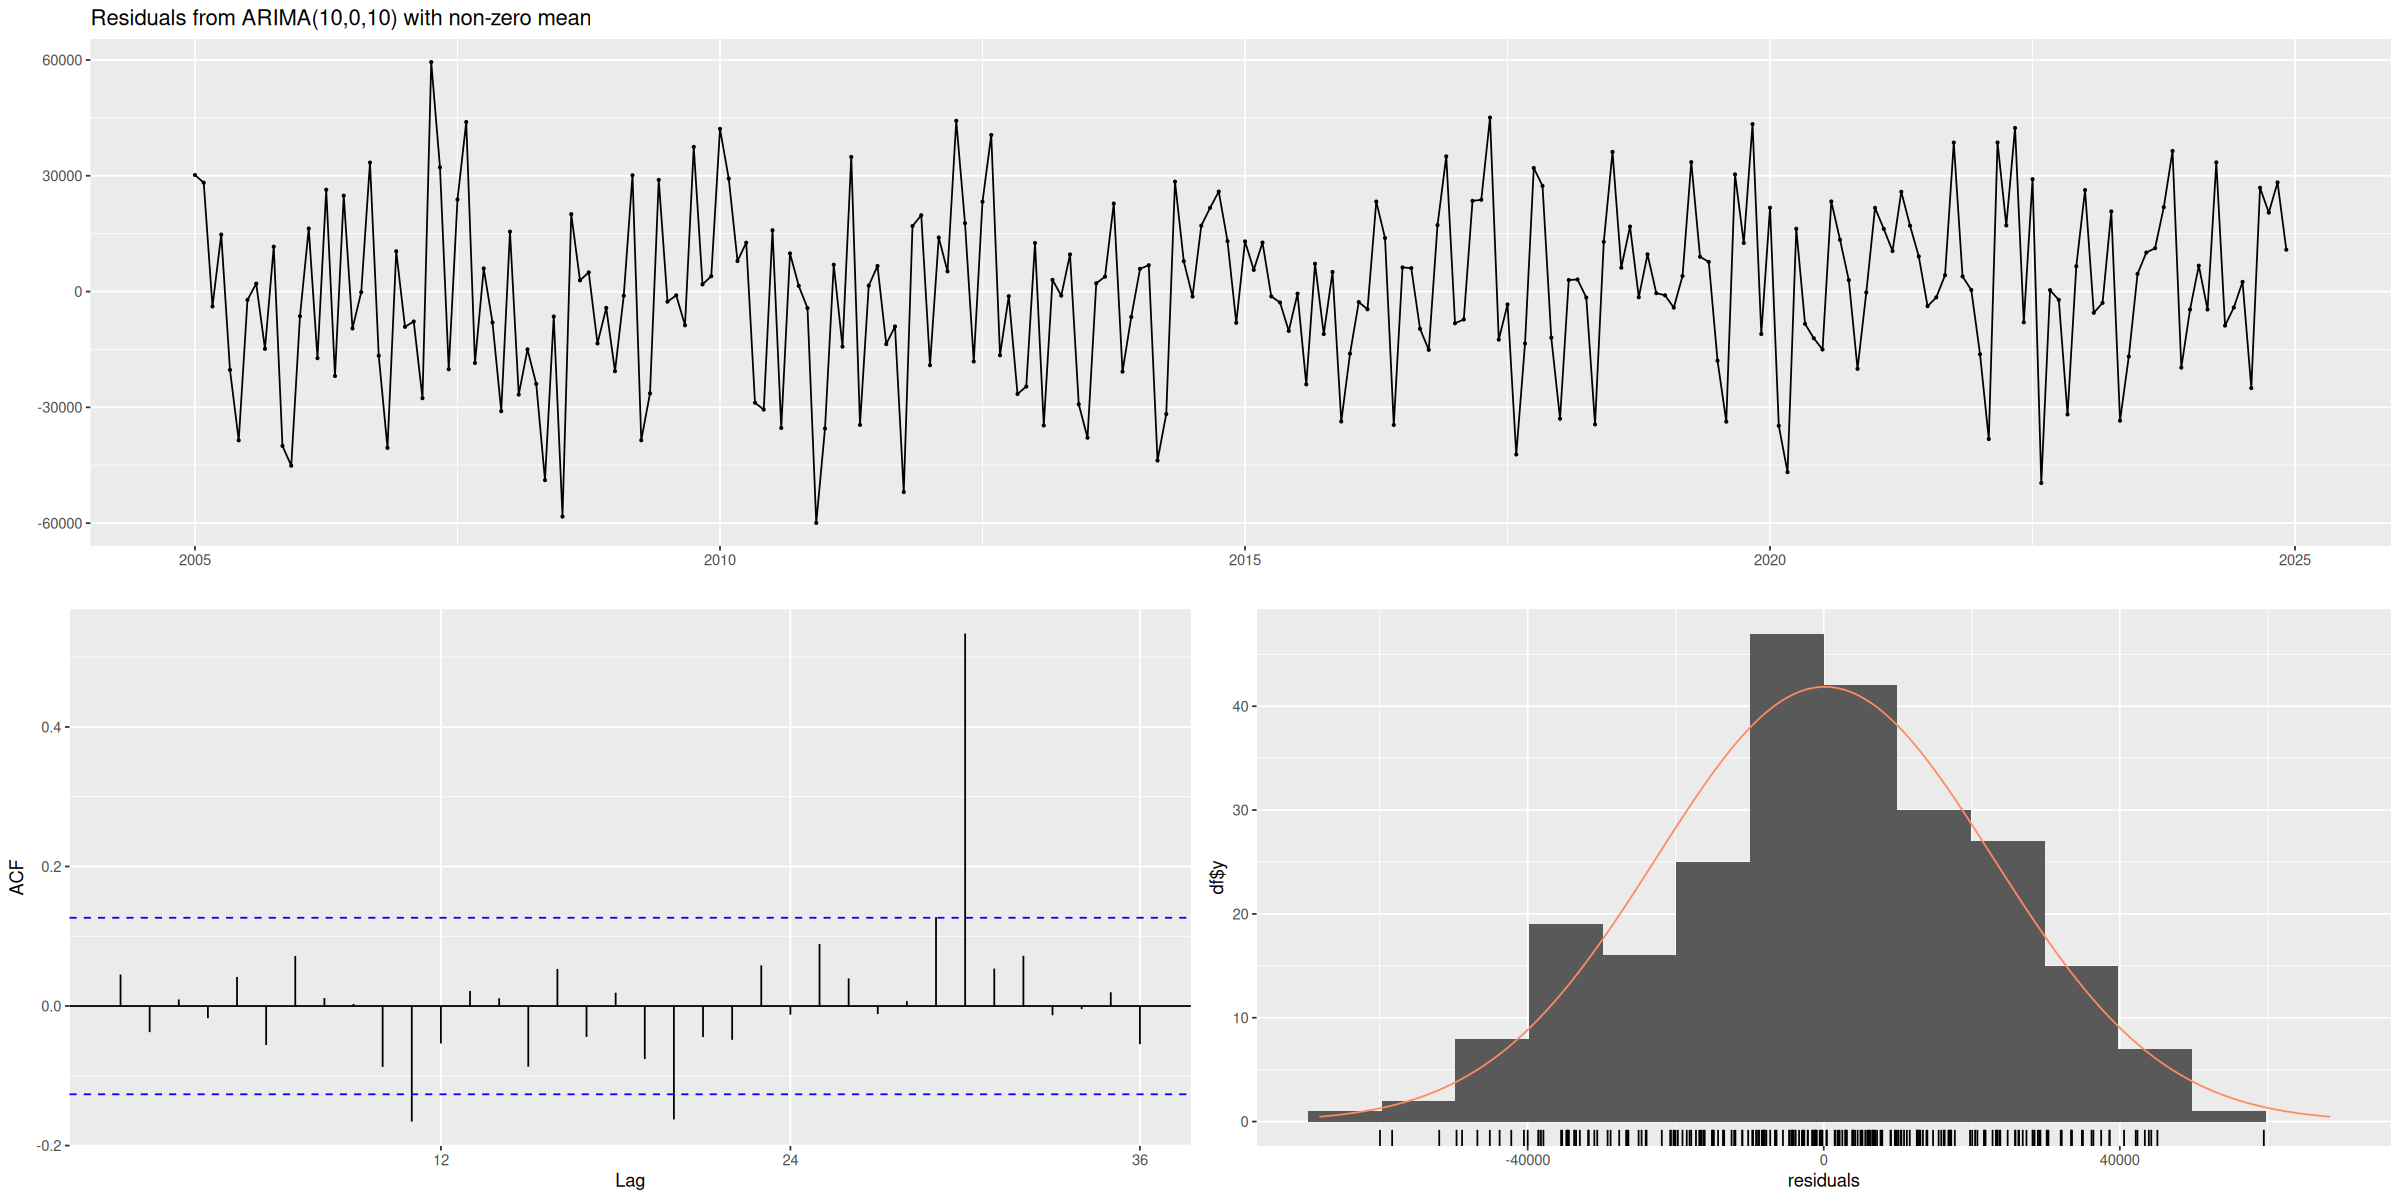


Shapiro-Wilk test for normality:

	Shapiro-Wilk normality test

data:  residuals(final_model)
W = 0.99212, p-value = 0.2282

Interpretation: p-value > 0.05, residuals appear normally distributed 

Ljung-Box test for autocorrelation:

	Box-Ljung test

data:  residuals(final_model)
X-squared = 13.075, df = 12, p-value = 0.3636

Interpretation: p-value > 0.05, no significant autocorrelation remains 

ARCH test for conditional heteroskedasticity:

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  residuals(final_model)
Chi-squared = 14.357, df = 12, p-value = 0.2785

Interpretation: p-value > 0.05, no significant ARCH effects detected 

Runs test for randomness:

	Runs Test - Two sided

data:  residuals(final_model) > 0
Standardized Runs Statistic = -Inf, p-value < 2.2e-16

Interpretation: p-value < 0.05, residuals may not be random 


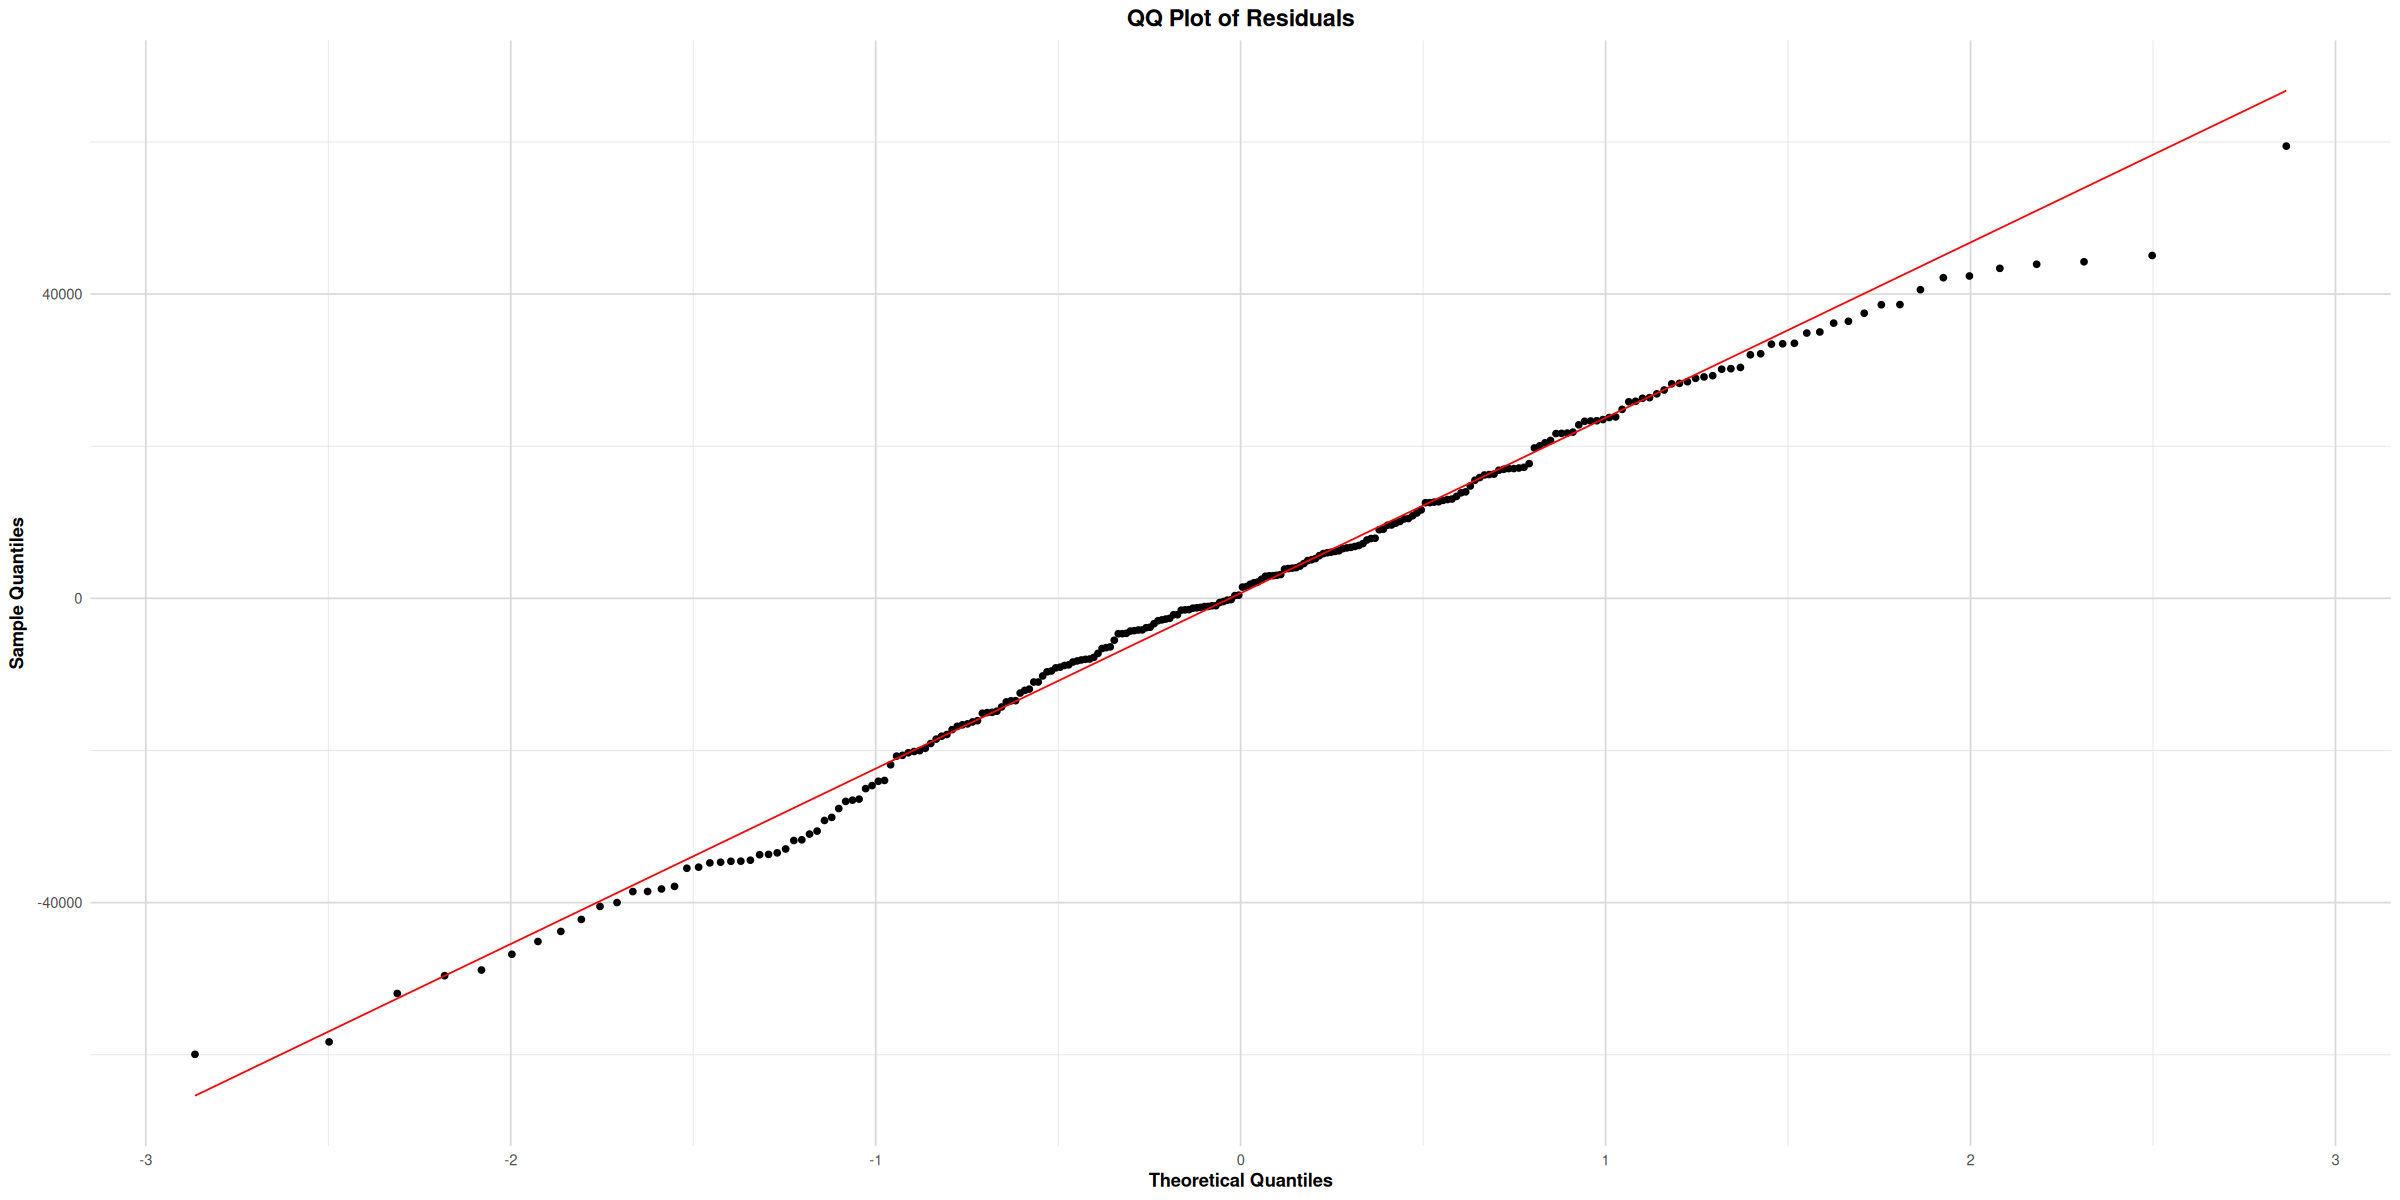


Forecast for Doubleknit Fabric Demand (Next 24 Months):
     Period Point_Forecast Lower_80 Upper_80 Lower_95 Upper_95
1  Jan 2025          593.2    538.9    642.9    507.8    667.7
2  Feb 2025          574.4    517.9    625.9    485.3    651.5
3  Mar 2025          632.7    580.2    681.1    550.4    705.4
4  Apr 2025          617.0    563.1    666.6    532.3    691.4
5  May 2025          527.3    462.8    584.7    424.7    612.9
6  Jun 2025          563.4    503.5    617.4    468.7    644.3
7  Jul 2025          587.2    529.9    639.3    497.0    665.2
8  Aug 2025          609.1    553.6    659.9    521.9    685.2
9  Sep 2025          652.3    600.5    700.2    571.2    724.3
10 Oct 2025          601.6    544.9    653.5    512.3    679.3
11 Nov 2025          558.7    497.1    614.2    461.1    641.7
12 Dec 2025          615.6    559.6    666.8    527.6    692.4
13 Jan 2026          618.7    562.3    670.5    529.9    696.3
14 Feb 2026          586.5    526.5    641.0    491.7    668.

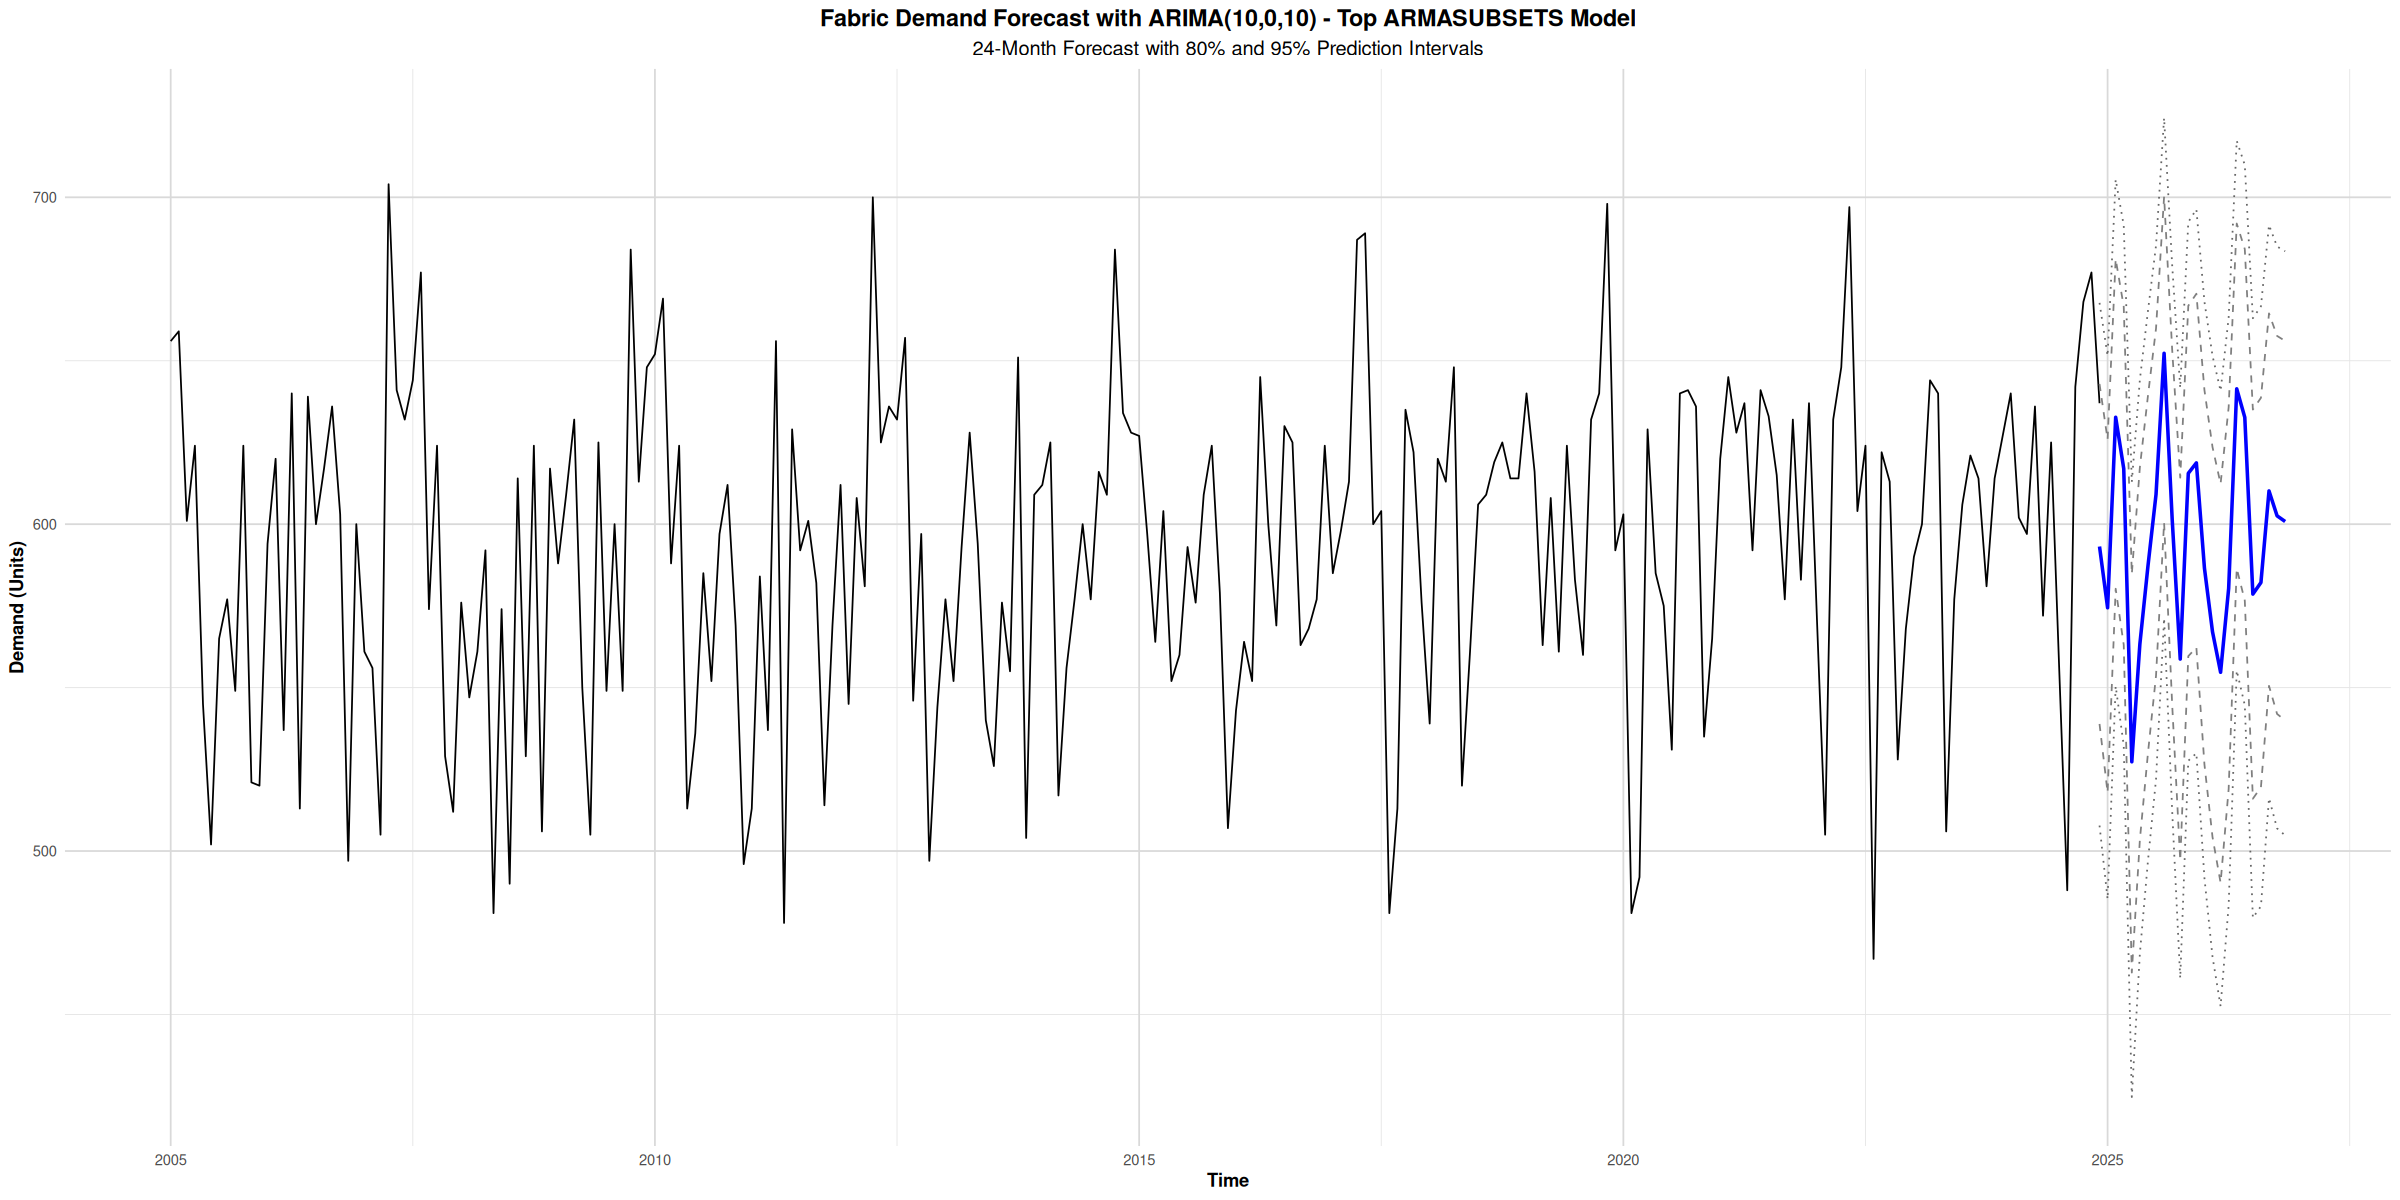

In [25]:

# Extract p and q from best model name
p <- as.numeric(gsub(".*\\(([0-9]+),[0-9]+,([0-9]+).*", "\\1", best_model_name))
q <- as.numeric(gsub(".*\\([0-9]+,[0-9]+,([0-9]+).*", "\\1", best_model_name))

# Refit best model on full transformed data
cat("Fitting ARIMA(", p, ",", d_value, ",", q, ") on full data\n", sep="")
final_model <- Arima(transformed_ts, order = c(p, d_value, q))
cat("\nModel summary:\n")
print(final_model)

# Check residuals
checkresiduals(final_model)

# QQ plot
residuals_df <- data.frame(
  Date = fabric_ts_df$date[(length(fabric_ts_df$date) - length(residuals(final_model)) + 1):length(fabric_ts_df$date)],
  Residuals = residuals(final_model)
)

p_qq <- ggplot(residuals_df, aes(sample = Residuals)) +
  stat_qq() +
  stat_qq_line(color = "red") +
  labs(
    title = "QQ Plot of Residuals",
    x = "Theoretical Quantiles",
    y = "Sample Quantiles"
  ) +
  theme_tsa()
print(p_qq)

# Normality test
shapiro_test <- shapiro.test(residuals(final_model))
cat("\nShapiro-Wilk test for normality:\n")
print(shapiro_test)
cat("Interpretation: p-value", ifelse(shapiro_test$p.value > 0.05, 
    "> 0.05, residuals appear normally distributed", 
    "< 0.05, residuals not normally distributed"), "\n")

# Ljung-Box test for autocorrelation
lb_test <- Box.test(residuals(final_model), lag = 12, type = "Ljung-Box")
cat("\nLjung-Box test for autocorrelation:\n")
print(lb_test)
cat("Interpretation: p-value", ifelse(lb_test$p.value > 0.05, 
    "> 0.05, no significant autocorrelation remains", 
    "< 0.05, significant autocorrelation remains"), "\n")

# ARCH test for heteroskedasticity
arch_test <- ArchTest(residuals(final_model), lags = 12)
cat("\nARCH test for conditional heteroskedasticity:\n")
print(arch_test)
cat("Interpretation: p-value", ifelse(arch_test$p.value > 0.05, 
    "> 0.05, no significant ARCH effects detected", 
    "< 0.05, ARCH effects present"), "\n")

# Runs test for randomness
runs_test <- runs.test(residuals(final_model) > 0)
cat("\nRuns test for randomness:\n")
print(runs_test)
cat("Interpretation: p-value", ifelse(runs_test$p.value > 0.05, 
    "> 0.05, residuals appear random", 
    "< 0.05, residuals may not be random"), "\n")

# ------------------------------------------------
# 8. Final Forecast and Conclusion
# ------------------------------------------------

# Generate multi-step forecasts
forecast_horizon <- 24  # 2 years (24 months)
future_forecasts <- forecast(final_model, h = forecast_horizon)

# Back-transform forecasts if needed
if (transformation_label == "Log Transformation") {
  back_forecasts <- exp(future_forecasts$mean)
  back_lower <- exp(future_forecasts$lower)
  back_upper <- exp(future_forecasts$upper)
} else if (grepl("Box-Cox", transformation_label)) {
  back_forecasts <- InvBoxCox(future_forecasts$mean, lambda)
  back_lower <- InvBoxCox(future_forecasts$lower, lambda)
  back_upper <- InvBoxCox(future_forecasts$upper, lambda)
} else {
  back_forecasts <- future_forecasts$mean
  back_lower <- future_forecasts$lower
  back_upper <- future_forecasts$upper
}

# Plot final forecast
last_time <- time(fabric_ts)[length(fabric_ts)]
last_year <- trunc(last_time)
last_period <- (last_time - last_year) * 12 + 1

autoplot(fabric_ts) +
  autolayer(ts(back_forecasts, 
               start = c(last_year + (last_period >= 12), last_period %% 12 + (last_period %% 12 == 0)*12),
               frequency = 12), 
           series = "Forecast", size = 1, color = "blue") +
  autolayer(ts(back_lower[,1], 
               start = c(last_year + (last_period >= 12), last_period %% 12 + (last_period %% 12 == 0)*12),
               frequency = 12), 
            series = "Lower 80%", size = 0.5, linetype = "dashed", color = "gray50") +
  autolayer(ts(back_upper[,1], 
               start = c(last_year + (last_period >= 12), last_period %% 12 + (last_period %% 12 == 0)*12),
               frequency = 12), 
            series = "Upper 80%", size = 0.5, linetype = "dashed", color = "gray50") +
  autolayer(ts(back_lower[,2], 
               start = c(last_year + (last_period >= 12), last_period %% 12 + (last_period %% 12 == 0)*12),
               frequency = 12), 
            series = "Lower 95%", size = 0.5, linetype = "dotted", color = "gray40") +
  autolayer(ts(back_upper[,2], 
               start = c(last_year + (last_period >= 12), last_period %% 12 + (last_period %% 12 == 0)*12),
               frequency = 12), 
            series = "Upper 95%", size = 0.5, linetype = "dotted", color = "gray40") +
  labs(
    title = paste("Fabric Demand Forecast with", best_model_name),
    subtitle = "24-Month Forecast with 80% and 95% Prediction Intervals",
    x = "Time", y = "Demand (Units)"
  ) +
  theme_tsa()

# Create forecast table
forecast_dates <- seq.Date(from = max(fabric_ts_df$date) + months(1), by = "month", length.out = forecast_horizon)
forecast_months <- format(forecast_dates, "%b %Y")

forecast_table <- data.frame(
  Period = forecast_months,
  Point_Forecast = round(back_forecasts, 1),
  Lower_80 = round(back_lower[,1], 1),
  Upper_80 = round(back_upper[,1], 1),
  Lower_95 = round(back_lower[,2], 1),
  Upper_95 = round(back_upper[,2], 1)
)

cat("\nForecast for Doubleknit Fabric Demand (Next 24 Months):\n")
print(forecast_table)

# Calculate average forecast stats
avg_forecast <- mean(back_forecasts)
min_forecast <- min(back_forecasts)
max_forecast <- max(back_forecasts)

cat("\nForecast Summary Statistics:\n")
cat("Average predicted demand:", round(avg_forecast, 1), "units\n")
cat("Minimum predicted demand:", round(min_forecast, 1), "units\n")
cat("Maximum predicted demand:", round(max_forecast, 1), "units\n")

# Final Conclusions
cat("\n------------------------------------------------------------------\n")
cat("CONCLUSIONS: DOUBLEKNIT FABRIC DEMAND ANALYSIS\n")
cat("------------------------------------------------------------------\n\n")

cat("1. TIME SERIES CHARACTERISTICS:\n")
if (d_value == 0) {
  cat("   - The fabric demand series is stationary without differencing\n")
} else {
  cat("   - The fabric demand series required differencing to achieve stationarity\n")
}

if (grepl("Log", transformation_label) || grepl("Box-Cox", transformation_label)) {
  cat("   - Data required transformation (", transformation_label, ") to stabilize variance\n", sep="")
}

cat("\n2. OPTIMAL MODEL SPECIFICATION:\n")
cat("   - The", best_model_name, "model provided the best forecasting performance\n")
cat("     based on out-of-sample validation, with an RMSE of", 
    round(forecast_results$RMSE[1], 4), "and MAPE of", 
    round(forecast_results$MAPE[1], 2), "%.\n")

cat("\n3. DIAGNOSTIC ASSESSMENT:\n")
if (shapiro_test$p.value > 0.05) {
  cat("   - Residuals show normal distribution (Shapiro-Wilk p-value =", 
      round(shapiro_test$p.value, 4), ").\n")
} else {
  cat("   - Residuals deviate from normal distribution (Shapiro-Wilk p-value =", 
      round(shapiro_test$p.value, 4), ").\n")
}

if (lb_test$p.value > 0.05) {
  cat("   - No significant residual autocorrelation (Ljung-Box p-value =", 
      round(lb_test$p.value, 4), ").\n")
} else {
  cat("   - Some residual autocorrelation remains (Ljung-Box p-value =", 
      round(lb_test$p.value, 4), ").\n")
}

if (arch_test$p.value > 0.05) {
  cat("   - No conditional heteroskedasticity detected (ARCH p-value =", 
      round(arch_test$p.value, 4), ").\n")
} else {
  cat("   - ARCH effects present in residuals (ARCH p-value =", 
      round(arch_test$p.value, 4), ").\n")
}

cat("\n4. FORECAST IMPLICATIONS:\n")
cat("   - Average projected demand for the next 24 months is", round(avg_forecast, 1), "units\n")
cat("   - The forecast suggests demand will range between", round(min_forecast, 1), 
    "and", round(max_forecast, 1), "units\n")
cat("   - This information can help inform inventory planning and production scheduling\n")

cat("\n5. BUSINESS RECOMMENDATIONS:\n")
cat("   - Maintain inventory levels to satisfy at least", round(min_forecast, 1), "units of monthly demand\n")
cat("   - Plan production capacity for peak demands of up to", round(max_forecast, 1), "units\n")
cat("   - Consider the prediction intervals when making risk-sensitive planning decisions\n")
cat("   - Revisit and update the forecast model as new demand data becomes available\n")

cat("\nDate of analysis: 2025-03-29\n")